# Final Project: Emotion Analysis on 1.6 million tweets

### <span style="color:chocolate"> Motivation </span>


*   The model can be used for personalized content recommendations, such as advertisements, public postings, and interactions.
*   The model can be used for tracking people's attitude towards certain social events.





### <span style="color:chocolate"> Data Source </span>

We would perform sentiment analysis with 1,600,000 tweets extracted from twitter. It contains the following 6 fields:


*   **target**: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
*   **ids**: The id of the tweet ( 2087)
*   **date**: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
*   **flag**: The query (lyx). If there is no query, then this value is NO_QUERY.

*   **user**: the user that tweeted (robotickilldozr)

*   **text**: the text of the tweet ("Lyx is cool")

According to the creators of the dataset:

"Our approach was unique because our training data was automatically created, as opposed to having humans manual annotate tweets. In our approach, we assume that any tweet with positive emoticons, like :), were positive, and tweets with negative emoticons, like :(, were negative. We used the Twitter Search API to collect these tweets by using keyword search"

The original dataset is from Kaggle: https://www.kaggle.com/datasets/kazanova/sentiment140

---
### Import Libraries and load data:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
# Load dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/Final_Project/tweets.csv'

# Load the CSV file
df_full = pd.read_csv(file_path, encoding='latin1', header=None)
df = df_full.sample(frac=0.025, random_state=1)
print(df.shape)

(40000, 6)


In [4]:
# Assign column names
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
sentiment_map = {0: "negative", 2: "neutral", 4: "positive"}
def convert_label(x):
  return sentiment_map[x]
df['sentiment'] = df['target'].apply(convert_label)
df.head()

target         ids                          date      flag  \
514293       0  2190584004  Tue Jun 16 03:08:48 PDT 2009  NO_QUERY   
142282       0  1881451988  Fri May 22 04:42:15 PDT 2009  NO_QUERY   
403727       0  2058252964  Sat Jun 06 14:34:17 PDT 2009  NO_QUERY   
649503       0  2237307600  Fri Jun 19 05:34:22 PDT 2009  NO_QUERY   
610789       0  2224301193  Thu Jun 18 09:20:06 PDT 2009  NO_QUERY   

               user                                               text  \
514293    Vicki_Gee  i miss nikki nu nu already  shes always there ...   
142282    PatCashin  So I had a dream last night. I  remember a sig...   
403727  deelectable  @girlyghost ohh poor sickly you   (((hugs)) ho...   
649503  justinekepa                               it is raining again    
610789     cmatt007          @MissKeriBaby wish I was in LA right now    

       sentiment  
514293  negative  
142282  negative  
403727  negative  
649503  negative  
610789  negative

In [5]:
# Check different values of the target variable and count each one
target_counts = df['target'].value_counts()
print("Target value counts:\n", target_counts)

Target value counts:
 target
4    20047
0    19953
Name: count, dtype: int64


In [6]:
#Check for missing values
print(df.isnull().sum())

target       0
ids          0
date         0
flag         0
user         0
text         0
sentiment    0
dtype: int64


### 🔦Exploratory Data Analysis

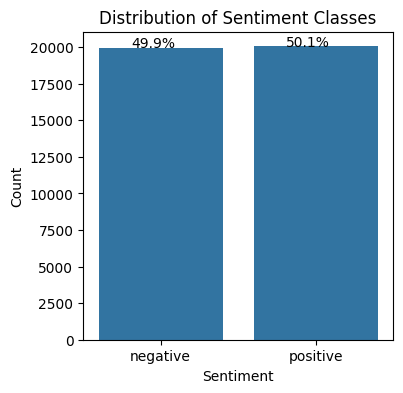

In [7]:
#Plotting of sentiment distribution - not necessary at all since it is 50/50
plt.figure(figsize=(4,4))
ax = sns.countplot(x='sentiment', data=df)
plt.title('Distribution of Sentiment Classes')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Calculate the percentages and annotate each bar
total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center')

plt.show()

Plot of the tweet lengths distribution - Based on the plot, 100 will be a reasonable cut.

In [8]:
tweets = df['text']
labels = df['target']

positive = []
negative = []

for x,y in zip(tweets, labels):
  if y == 4:
    positive.append(len(x))
  elif y == 0:
    negative.append(len(x))
print(f'Positive review length: minimum: {min(positive)}, maximum: {max(positive)}, mean: {np.array(positive).mean()}')
print(f'Negative review length: minimum: {min(negative)}, maximum: {max(negative)}, mean: {np.array(negative).mean()}')

Positive review length: minimum: 8, maximum: 220, mean: 73.60398064548312
Negative review length: minimum: 6, maximum: 201, mean: 73.97098180724703


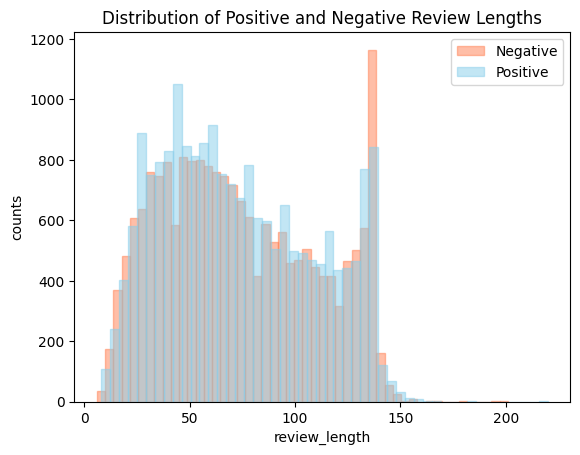

In [9]:
plt.hist(negative, bins = 50, label='Negative', color='coral', ec='coral', alpha=0.5)
plt.hist(positive, bins = 50, label='Positive', color="skyblue", ec='skyblue', alpha=0.5)
plt.xlabel('review_length')
plt.ylabel('counts')
plt.title('Distribution of Positive and Negative Review Lengths')
plt.legend(loc="upper right")
plt.show()

### ✂️Data Preprocessing

In [10]:
# Preprocess the text data
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].str.replace(r'http\S+', '', regex=True)  # Remove URLs
df['text'] = df['text'].str.replace(r'@\w+', '', regex=True)     # Remove mentions
df['text'] = df['text'].str.replace(r'#\w+', '', regex=True)     # Remove hashtags
df['text'] = df['text'].str.replace(r'[^a-zA-Z\s]', '', regex=True)  # Remove special characters to reduce noise

In [11]:
df.head()

target         ids                          date      flag  \
514293       0  2190584004  Tue Jun 16 03:08:48 PDT 2009  NO_QUERY   
142282       0  1881451988  Fri May 22 04:42:15 PDT 2009  NO_QUERY   
403727       0  2058252964  Sat Jun 06 14:34:17 PDT 2009  NO_QUERY   
649503       0  2237307600  Fri Jun 19 05:34:22 PDT 2009  NO_QUERY   
610789       0  2224301193  Thu Jun 18 09:20:06 PDT 2009  NO_QUERY   

               user                                               text  \
514293    Vicki_Gee  i miss nikki nu nu already  shes always there ...   
142282    PatCashin  so i had a dream last night i  remember a sign...   
403727  deelectable   ohh poor sickly you   hugs hope you feel a li...   
649503  justinekepa                               it is raining again    
610789     cmatt007                        wish i was in la right now    

       sentiment  
514293  negative  
142282  negative  
403727  negative  
649503  negative  
610789  negative

In [12]:
%%time
# Tokenization and Padding
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(sequences, maxlen=100)
print(X.shape)
print(X[0])

(40000, 100)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   1
  80 188 358 174  81  84 774 153  53 681]
CPU times: user 1.1 s, sys: 11.6 ms, total: 1.11 s
Wall time: 1.12 s


In [13]:
# Adjust labels for binary classification (0 for negative, 1 for positive)
y = df['target'].apply(lambda x: 0 if x == 0 else 1).values

In [14]:
df.head()

target         ids                          date      flag  \
514293       0  2190584004  Tue Jun 16 03:08:48 PDT 2009  NO_QUERY   
142282       0  1881451988  Fri May 22 04:42:15 PDT 2009  NO_QUERY   
403727       0  2058252964  Sat Jun 06 14:34:17 PDT 2009  NO_QUERY   
649503       0  2237307600  Fri Jun 19 05:34:22 PDT 2009  NO_QUERY   
610789       0  2224301193  Thu Jun 18 09:20:06 PDT 2009  NO_QUERY   

               user                                               text  \
514293    Vicki_Gee  i miss nikki nu nu already  shes always there ...   
142282    PatCashin  so i had a dream last night i  remember a sign...   
403727  deelectable   ohh poor sickly you   hugs hope you feel a li...   
649503  justinekepa                               it is raining again    
610789     cmatt007                        wish i was in la right now    

       sentiment  
514293  negative  
142282  negative  
403727  negative  
649503  negative  
610789  negative

In [15]:
# Split dataset into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert labels to categorical format for binary classification
y_train = to_categorical(y_train, num_classes=2)
y_val = to_categorical(y_val, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

# Print shapes of the datasets
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_val:', X_val.shape)
print('Shape of y_val:', y_val.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

print(f'X_train sample: {X_train[0]}')
print(f'y_train sample: {y_train[0]}')

Shape of X_train: (32000, 100)
Shape of y_train: (32000, 2)
Shape of X_val: (4000, 100)
Shape of y_val: (4000, 2)
Shape of X_test: (4000, 100)
Shape of y_test: (4000, 2)
X_train sample: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0  737    1  695   10    4
 1006  866]
y_train sample: [0. 1.]


### 🌱Baseline Model & Hyperparameter Tuning

### Baseline Regression Model

In [16]:
# Build baseline model: logistic regression
def build_baseline_model(learning_rate = 0.001):

  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Input(shape=(100,)))

  model.add(tf.keras.layers.Dense(
      units=2,                     # output dim (for binary classification)
      activation="sigmoid"         # sigmoid activation for binary classification
  ))

  model.compile(loss='binary_crossentropy',   # this is a classification task
                optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), # default learning rate is 0.001
                metrics=['accuracy'])

  return model

Hyperparameter Tuning - Baseline Model

In [17]:
# Plotting function
def plot_metrics(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 4))

    # Plotting accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title(f'Training and validation accuracy\n: {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'Training and validation loss\n: {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [18]:
# Adding early stop if the loss becomes stable at early epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)

val_loss: 2.5947, val_accuracy: 0.5085


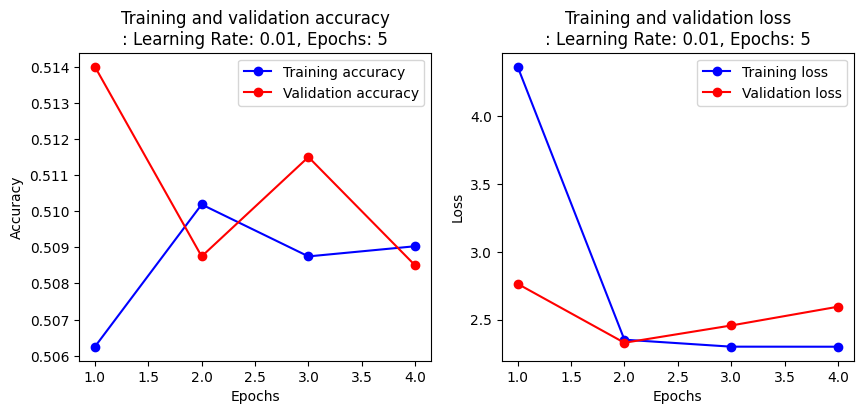



val_loss: 2.7612, val_accuracy: 0.5115


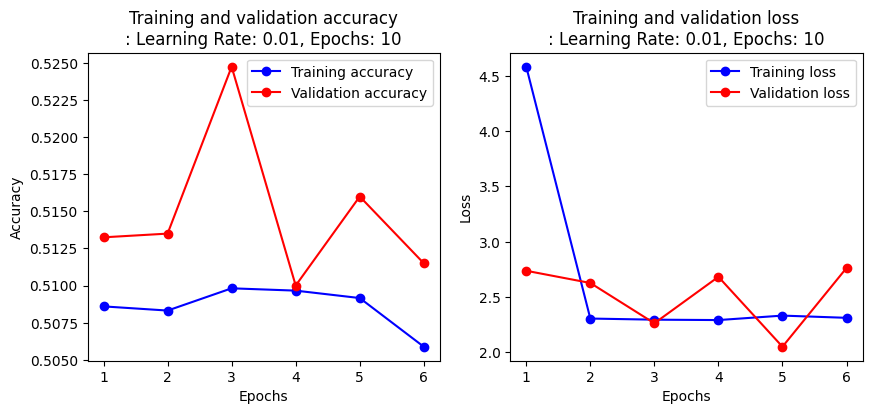



val_loss: 2.4717, val_accuracy: 0.5095


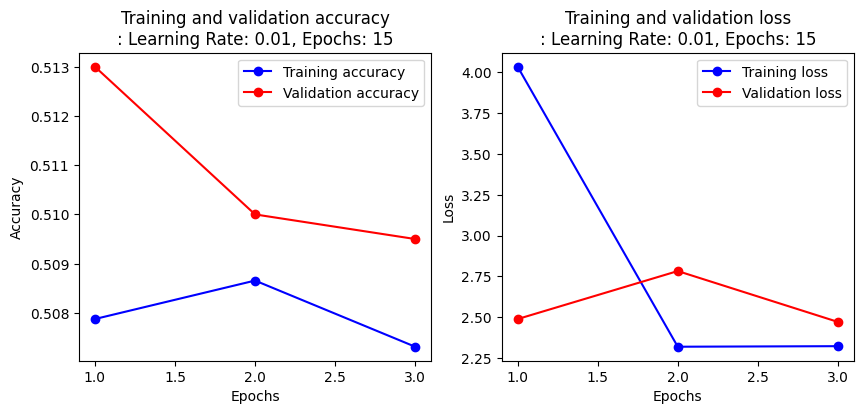



val_loss: 0.7909, val_accuracy: 0.5188


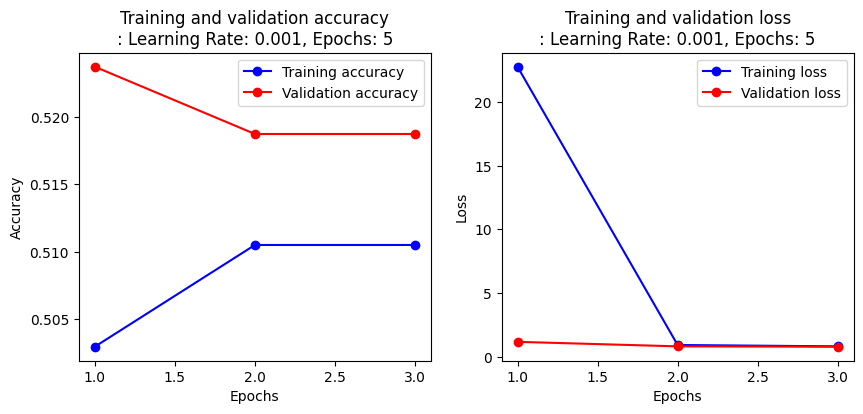



val_loss: 0.7845, val_accuracy: 0.5205


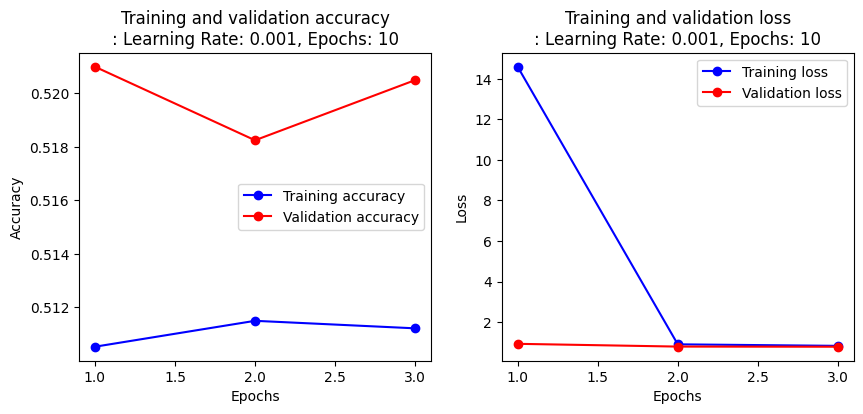



val_loss: 0.7769, val_accuracy: 0.5188


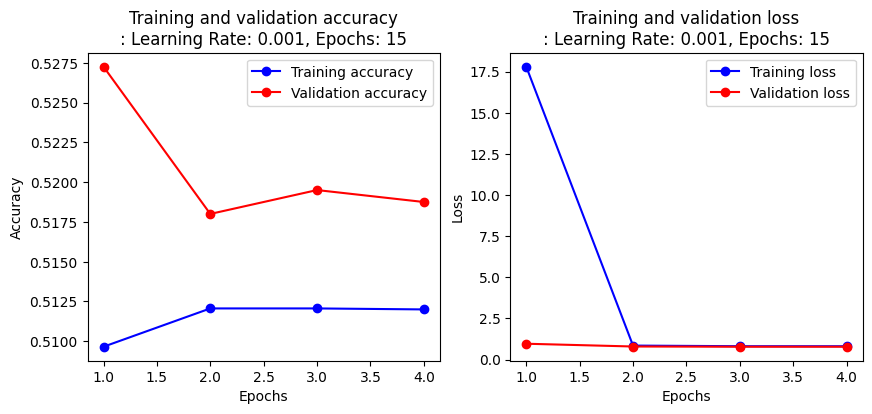



val_loss: 0.7455, val_accuracy: 0.5320


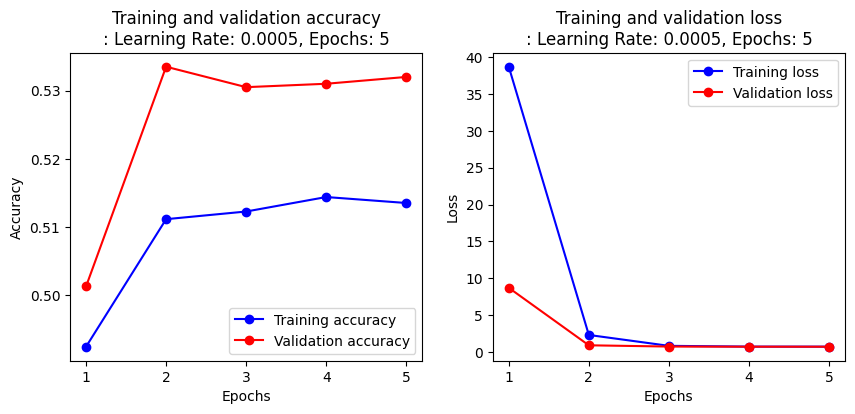



val_loss: 0.7500, val_accuracy: 0.5297


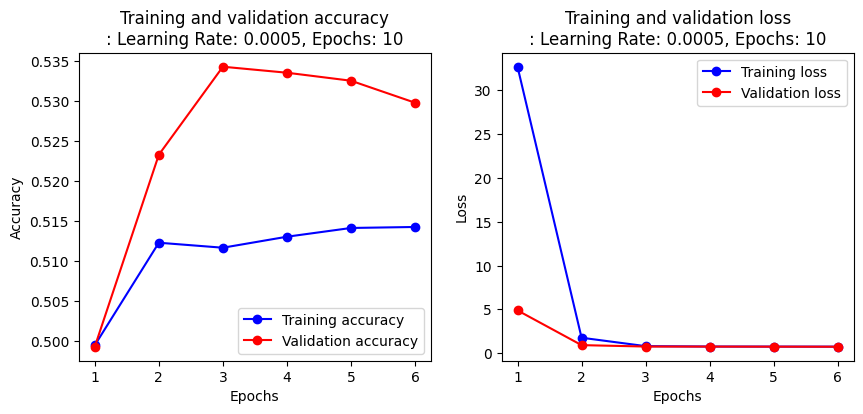



val_loss: 0.7860, val_accuracy: 0.5142


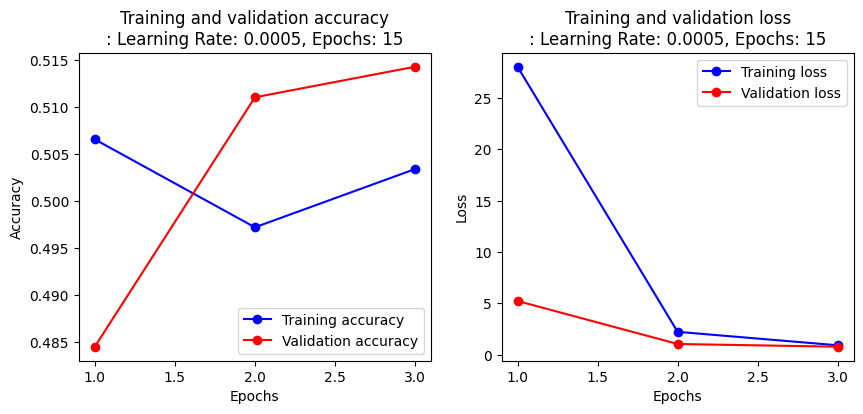



CPU times: user 52.6 s, sys: 3.89 s, total: 56.4 s
Wall time: 1min 3s


In [19]:
%%time
# Fine hypertuning for baseline model
learning_rate = [0.01, 0.001, 0.0005]
epochs = [5, 10, 15]

for l in learning_rate:
  for e in epochs:
    model1 = build_baseline_model(learning_rate = l)
    model1_history = model1.fit(
        x = X_train,
        y = y_train,          # corresponding binary labels
        epochs=e,             # number of passes through the training data
        batch_size=64,        # mini-batch size
        validation_data=(X_val, y_val), # use a fraction of the examples for validation
        verbose=0,
        callbacks=early_stopping
        )
    val_loss = model1_history.history['val_loss'][-1]
    val_accuracy = model1_history.history['val_accuracy'][-1]
    print(f'val_loss: {val_loss:.4f}, val_accuracy: {val_accuracy:.4f}')
    plot_metrics(model1_history, f'Learning Rate: {l}, Epochs: {e}')
    print('\n')


Final Baseline Model

In [20]:
%%time
# Finalize Baseline Model: Learning_rate = 0.0005, epochs = 15
model1 = build_baseline_model(learning_rate = 0.0005)
model1_history = model1.fit(
    x = X_train,
    y = y_train,          # corresponding binary labels
    epochs=15,             # number of passes through the training data
    batch_size=64,        # mini-batch size
    validation_data=(X_val, y_val), # use a fraction of the examples for validation
    verbose=0
    )

model1_score, model1_acc = model1.evaluate(X_test, y_test, batch_size=64)
print('Logistic Regression Baseline Test accuracy:', model1_acc)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5269 - loss: 0.7473
Logistic Regression Baseline Test accuracy: 0.5274999737739563
CPU times: user 15.9 s, sys: 1.1 s, total: 17 s
Wall time: 21.1 s


### ⭐Improvements

### CNN Model

In [21]:
# CNN model
def build_cnn_model(pool_size = 3):
  tf.keras.backend.clear_session()
  tf.random.set_seed(0)

  cnn_model = Sequential()
  cnn_model.add(tf.keras.layers.Input(shape=(100,)))
  cnn_model.add(Embedding(input_dim=4000, output_dim=128, input_length=100))
  cnn_model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
  cnn_model.add(MaxPooling1D(pool_size=pool_size))
  cnn_model.add(Flatten())
  cnn_model.add(Dense(128, activation='relu'))
  cnn_model.add(Dropout(0.1))
  cnn_model.add(Dense(64, activation='relu'))
  cnn_model.add(Dropout(0.1))
  cnn_model.add(Dense(2, activation='softmax'))

  cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return cnn_model


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


val_loss: 0.7790, val_accuracy: 0.7360


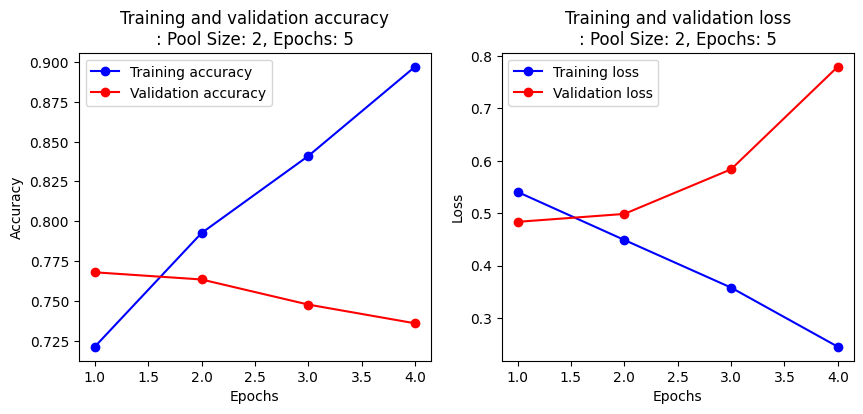



val_loss: 0.6958, val_accuracy: 0.7377


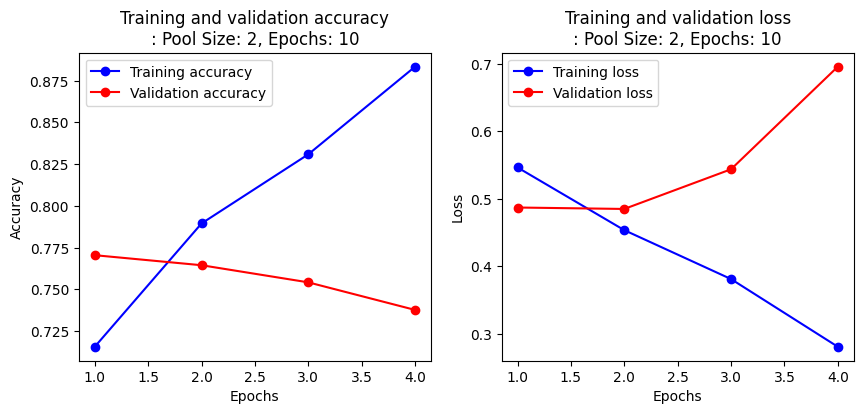



val_loss: 0.5778, val_accuracy: 0.7498


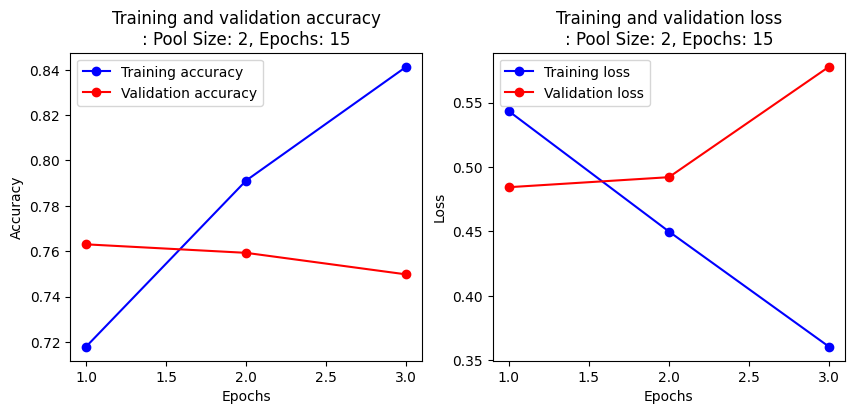



val_loss: 0.6093, val_accuracy: 0.7165


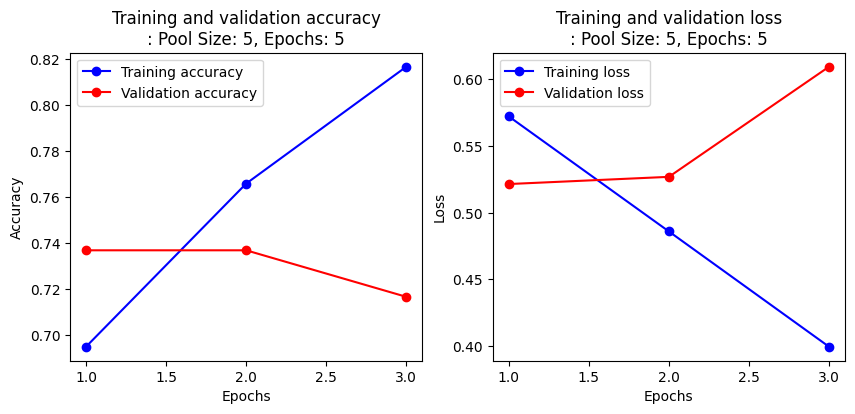



val_loss: 0.6109, val_accuracy: 0.7253


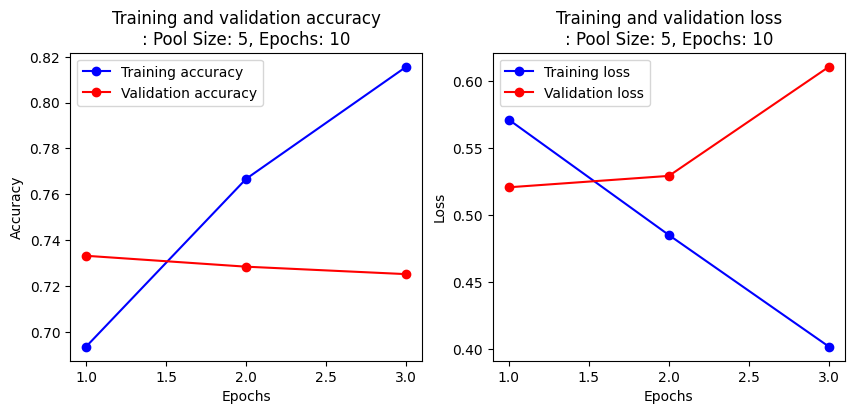



val_loss: 0.5874, val_accuracy: 0.7240


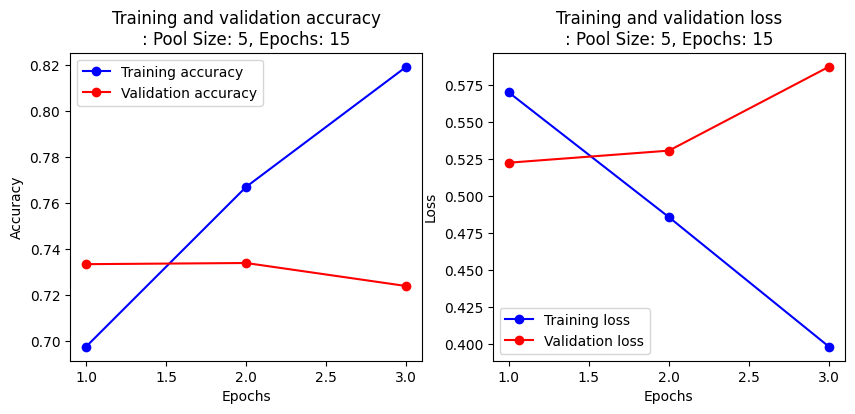



CPU times: user 1min 11s, sys: 2.91 s, total: 1min 14s
Wall time: 1min 38s


In [22]:
%%time
# Fine hypertuning for cnn_model
pool_sizes = [2, 5]
epochs = [5, 10, 15]
for p in pool_sizes:
  for e in epochs:
    cnn_model = build_cnn_model(pool_size = p)
    cnn_history = cnn_model.fit(X_train, y_train, epochs=e, batch_size=64, validation_data=(X_val, y_val), verbose=0, callbacks=early_stopping)
    val_loss = cnn_history.history['val_loss'][-1]
    val_accuracy = cnn_history.history['val_accuracy'][-1]
    print(f'val_loss: {val_loss:.4f}, val_accuracy: {val_accuracy:.4f}')
    plot_metrics(cnn_history, f'Pool Size: {p}, Epochs: {e}')
    print('\n')


In [23]:
# The final model: pool size: 2, epochs = 10
cnn_model = build_cnn_model(pool_size = 2)
cnn_history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_val, y_val), callbacks=early_stopping)

cnn_score, cnn_acc = cnn_model.evaluate(X_test, y_test, batch_size=64)
print('CNN Model Test accuracy:', cnn_acc)


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6562 - loss: 0.5957 - val_accuracy: 0.7670 - val_loss: 0.4819
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7863 - loss: 0.4572 - val_accuracy: 0.7650 - val_loss: 0.4883
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8282 - loss: 0.3816 - val_accuracy: 0.7475 - val_loss: 0.5812
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7637 - loss: 0.5448
CNN Model Test accuracy: 0.7562500238418579


### CNN Model Improvement - Replacing Embedding Layers with Word2Vec

Hyperparameter Tuning - Embedding Layer

In [24]:
%%time
import gensim.downloader as api

# Load Google's pre-trained Word2Vec model
word2vec = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded
CPU times: user 6min 10s, sys: 39.6 s, total: 6min 50s
Wall time: 12min 28s


In [25]:
# Create embedding matrix
'''
The result is a set of word vectors, where each word is represented by
a vector of fixed dimensionality (300 dimensions).
These vectors capture semantic relationships between words,
meaning that words with similar meanings are close to each other in the vector space.
'''
word_index = tokenizer.word_index
embedding_dim = 300  # Google Word2Vec uses 300-dimensional vectors
embedding_matrix = np.zeros((4000, embedding_dim))

for word, i in word_index.items():
    if i < 4000:
        try:
            embedding_vector = word2vec[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            # Words not found in the Word2Vec model will be all zeros.
            embedding_matrix[i] = np.random.randn(embedding_dim)

In [26]:
embedding_matrix.shape

(4000, 300)

In [27]:
def build_cnn_model2(pool_size=2, embedding_dim=300, kernel_size =5, filters=128):
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    cnn_model = Sequential()
    cnn_model.add(tf.keras.layers.Input(shape=(100,)))
    cnn_model.add(Embedding(input_dim=4000,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=100,
                            trainable=False))
    cnn_model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    cnn_model.add(MaxPooling1D(pool_size=pool_size))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(128, activation='relu'))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(64, activation='relu'))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(2, activation='softmax'))

    cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn_model

val_loss: 0.5041, val_accuracy: 0.7530


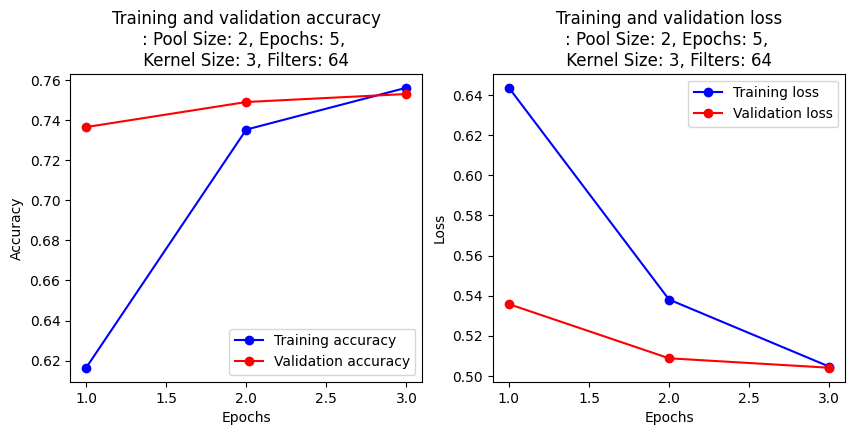



val_loss: 0.5043, val_accuracy: 0.7590


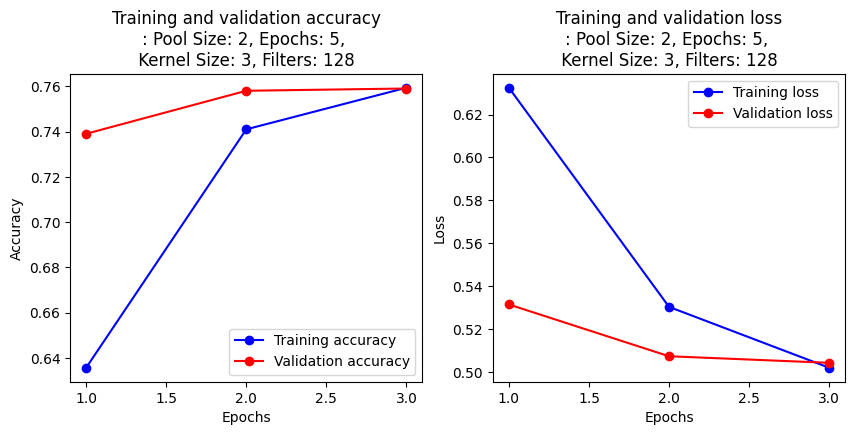



val_loss: 0.5092, val_accuracy: 0.7570


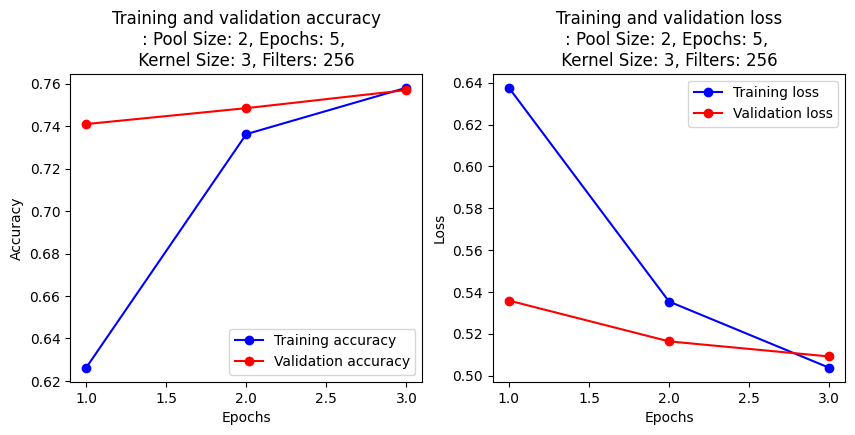



val_loss: 0.5071, val_accuracy: 0.7485


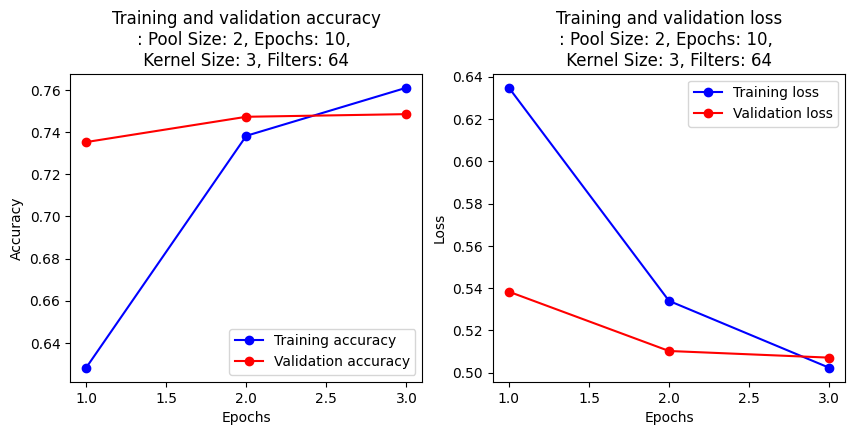



val_loss: 0.5049, val_accuracy: 0.7552


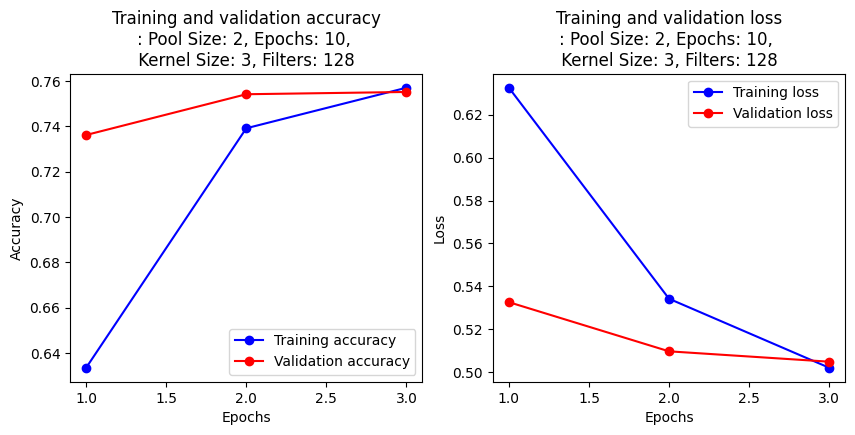



val_loss: 0.5146, val_accuracy: 0.7485


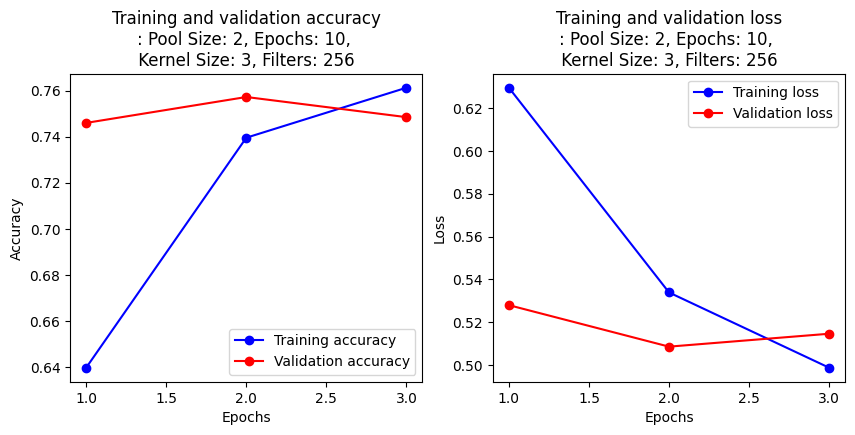



val_loss: 0.5048, val_accuracy: 0.7530


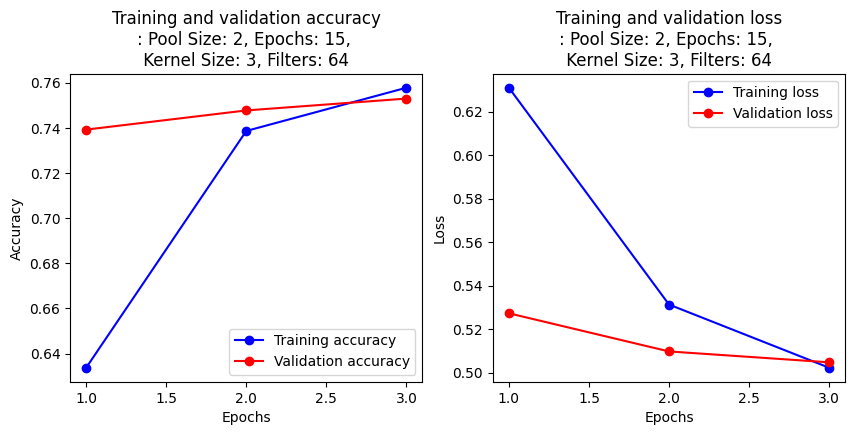



val_loss: 0.5018, val_accuracy: 0.7520


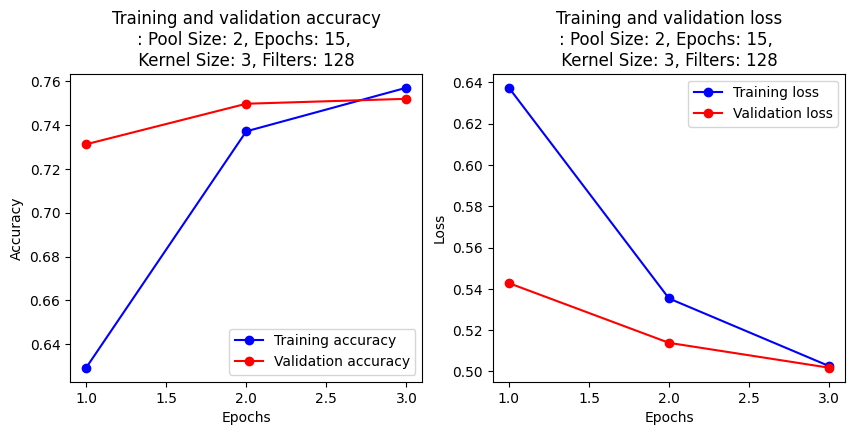



val_loss: 0.5106, val_accuracy: 0.7513


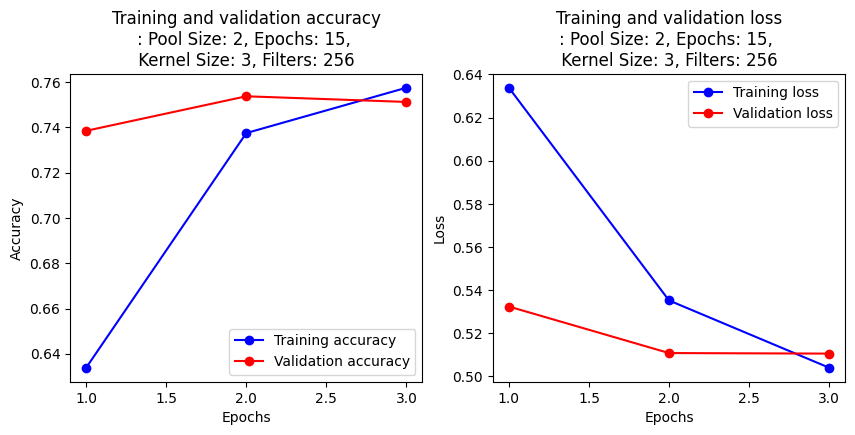



val_loss: 0.5204, val_accuracy: 0.7442


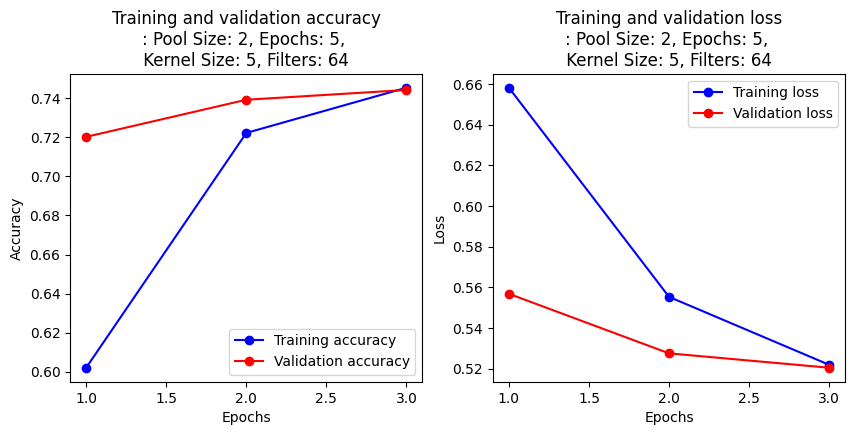



val_loss: 0.5190, val_accuracy: 0.7425


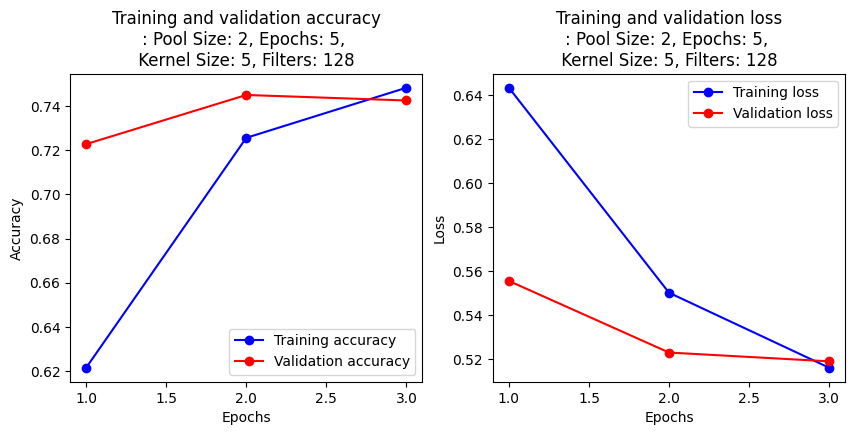



val_loss: 0.5234, val_accuracy: 0.7402


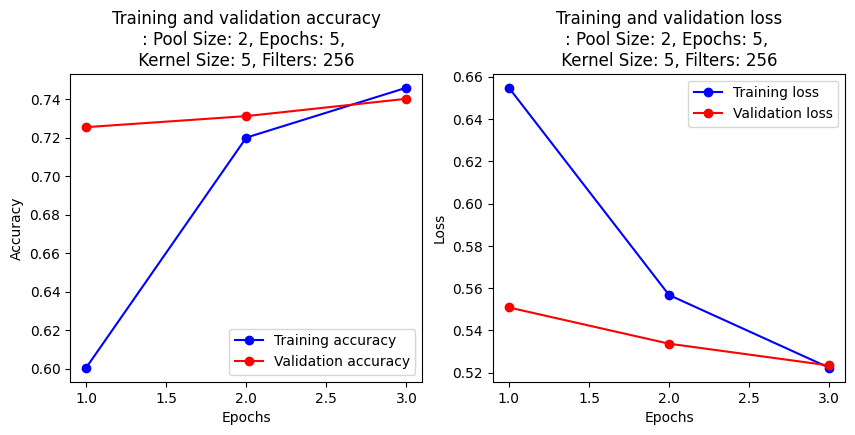



val_loss: 0.5228, val_accuracy: 0.7437


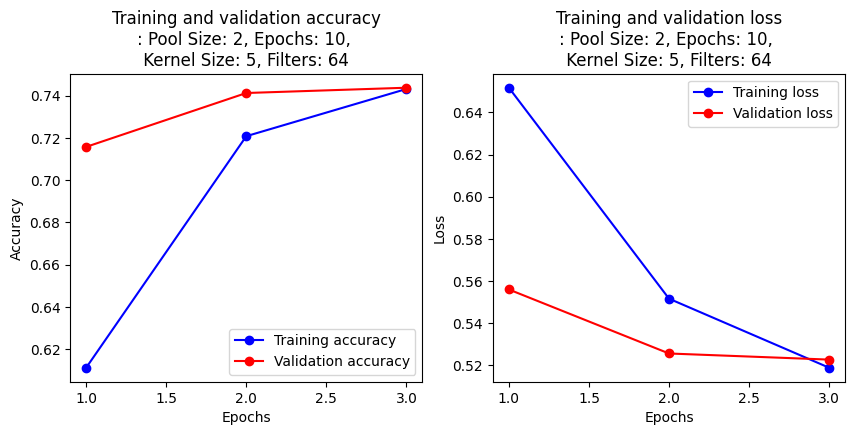



val_loss: 0.5268, val_accuracy: 0.7450


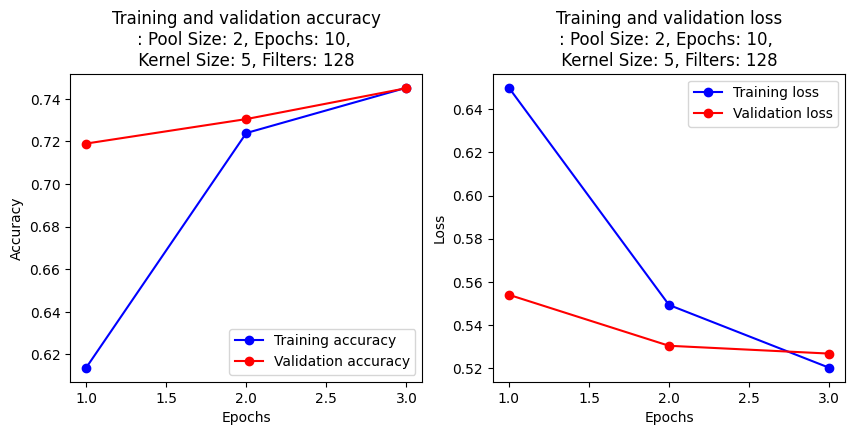



val_loss: 0.5229, val_accuracy: 0.7430


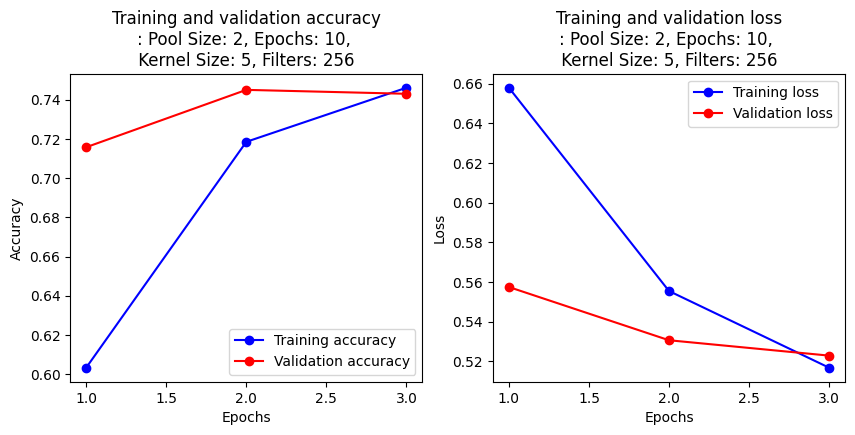



val_loss: 0.5161, val_accuracy: 0.7558


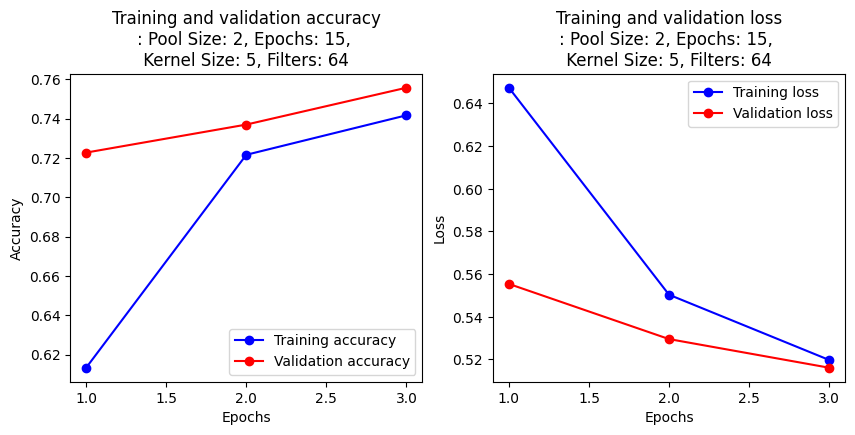



val_loss: 0.5149, val_accuracy: 0.7520


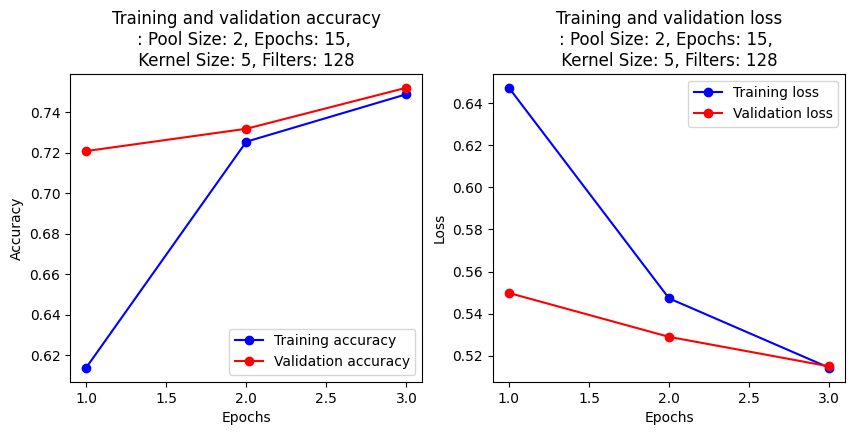



val_loss: 0.5147, val_accuracy: 0.7527


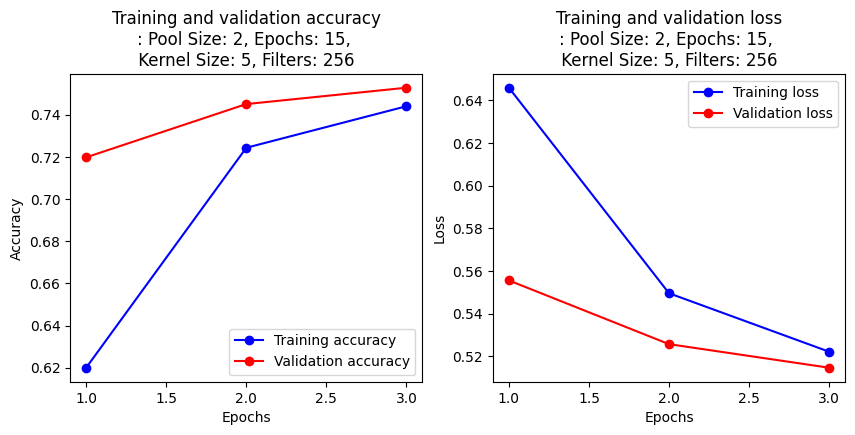



val_loss: 0.5179, val_accuracy: 0.7430


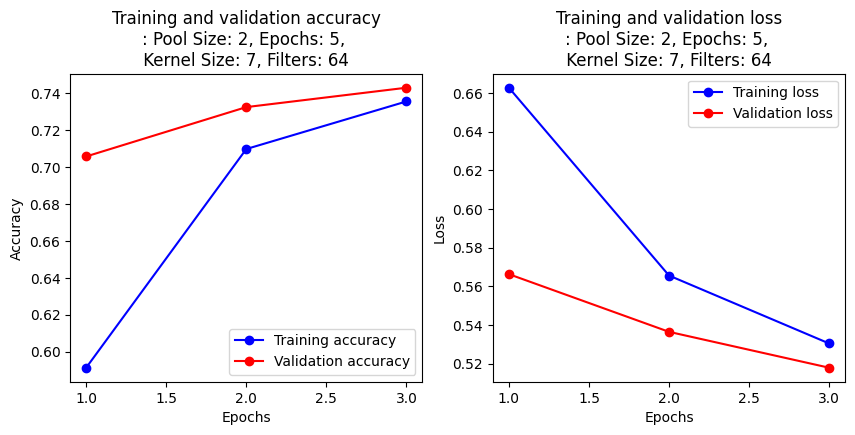



val_loss: 0.5214, val_accuracy: 0.7442


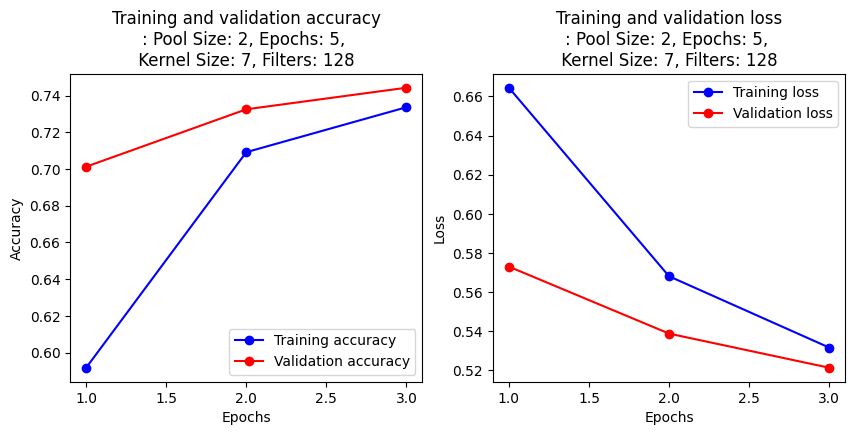



val_loss: 0.5227, val_accuracy: 0.7402


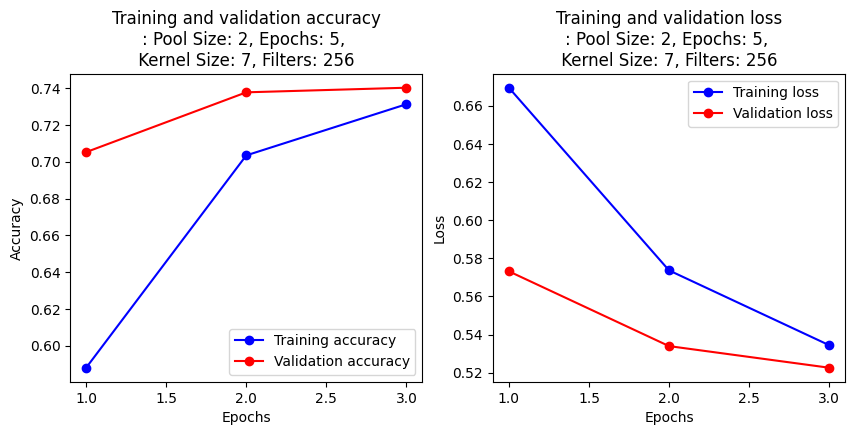



val_loss: 0.5254, val_accuracy: 0.7398


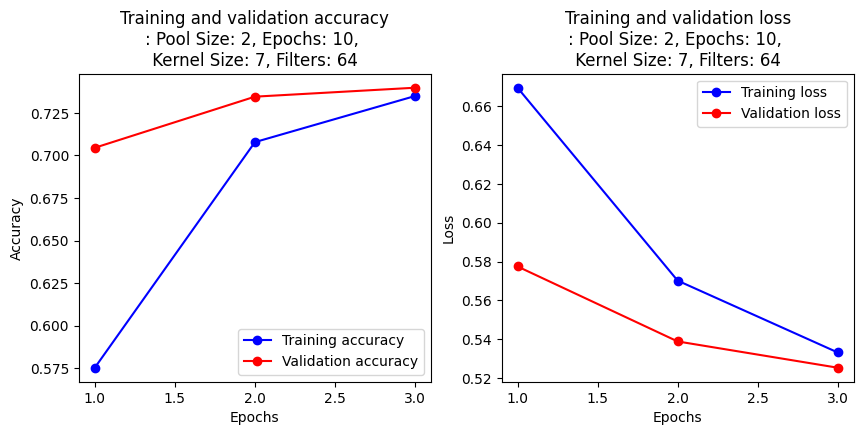



val_loss: 0.5263, val_accuracy: 0.7362


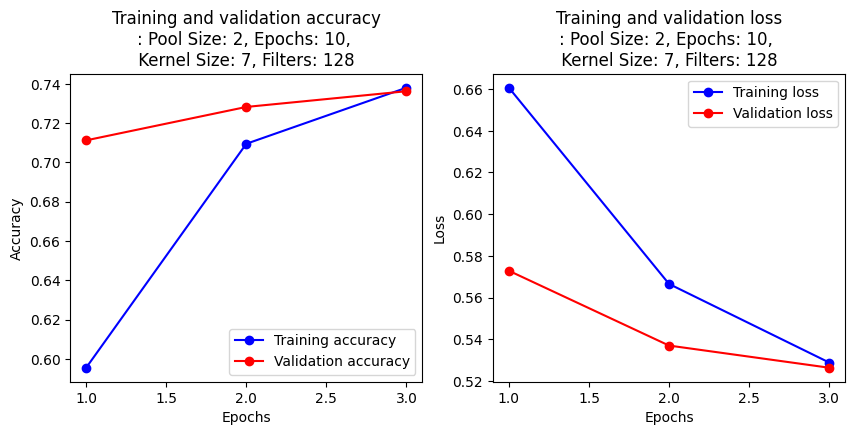



val_loss: 0.5175, val_accuracy: 0.7458


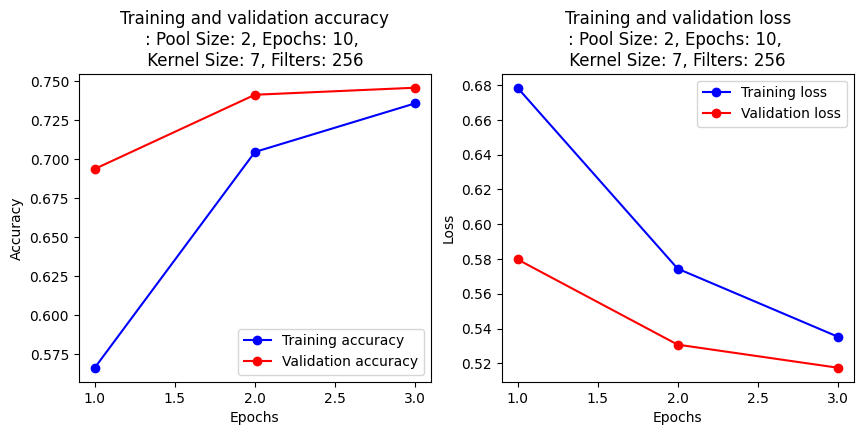



val_loss: 0.5212, val_accuracy: 0.7427


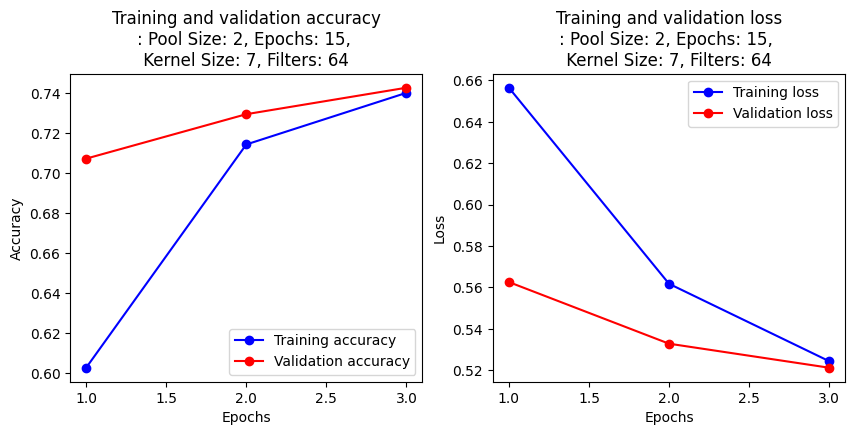



val_loss: 0.5250, val_accuracy: 0.7455


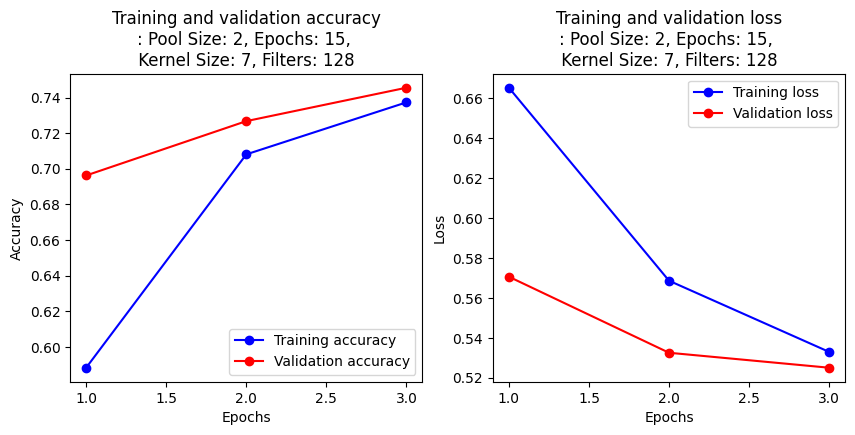



val_loss: 0.5190, val_accuracy: 0.7475


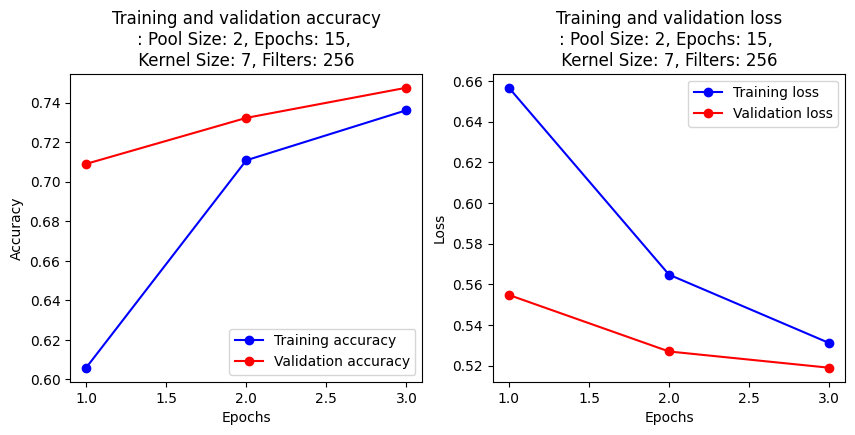



val_loss: 0.5917, val_accuracy: 0.6743


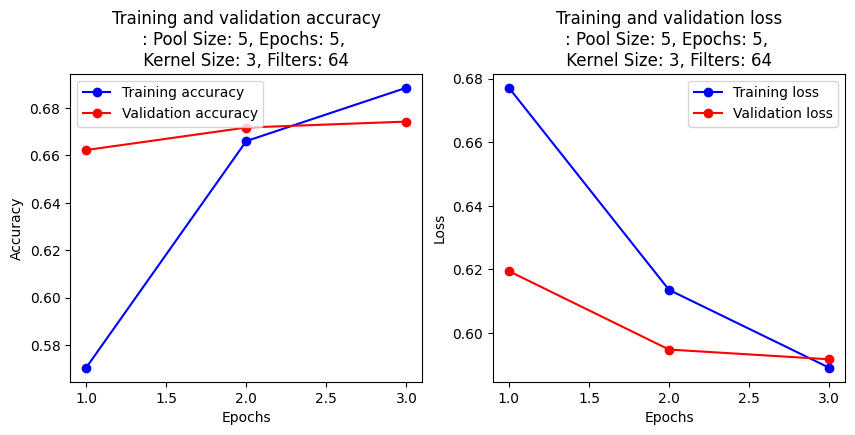



val_loss: 0.5941, val_accuracy: 0.6750


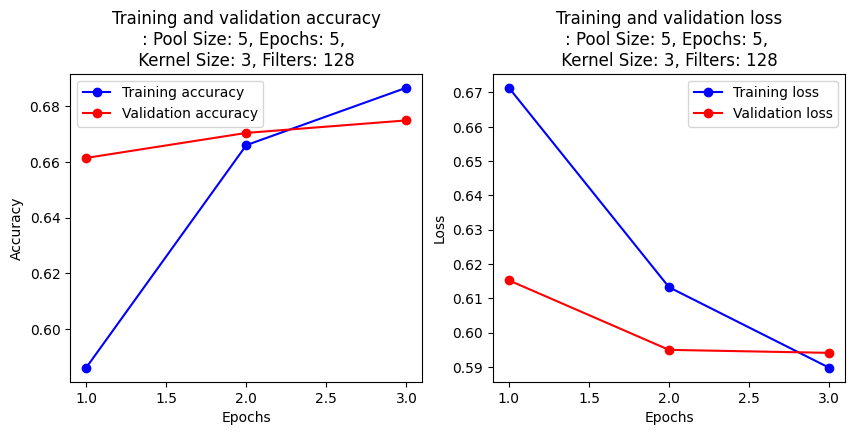



val_loss: 0.5895, val_accuracy: 0.6758


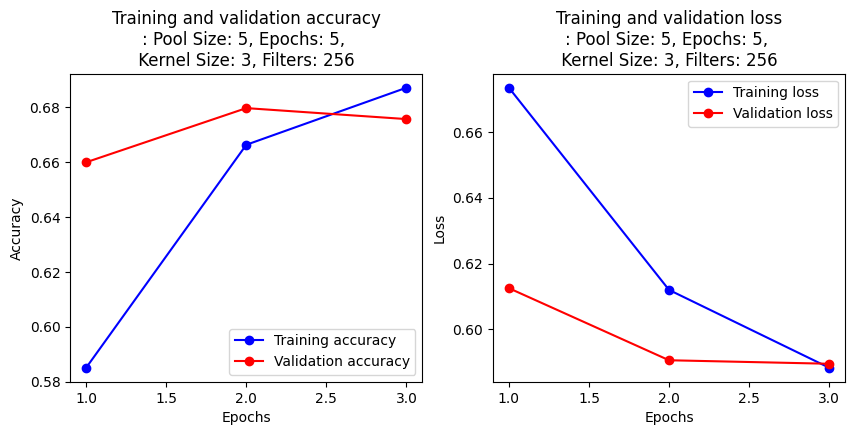



val_loss: 0.5936, val_accuracy: 0.6722


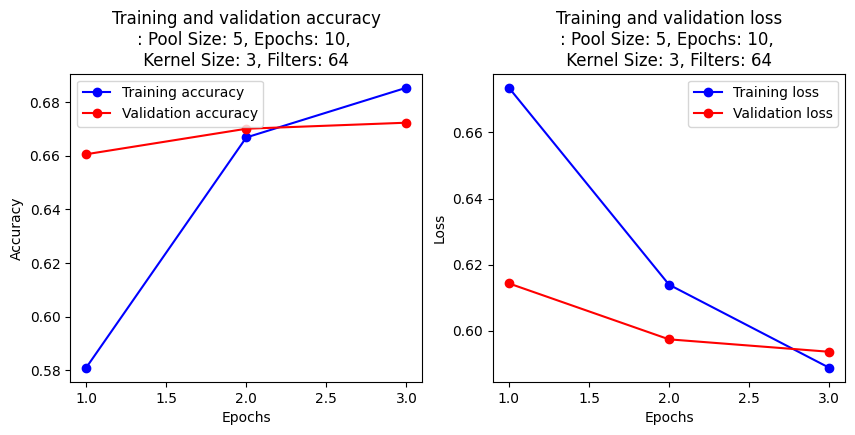



val_loss: 0.5942, val_accuracy: 0.6710


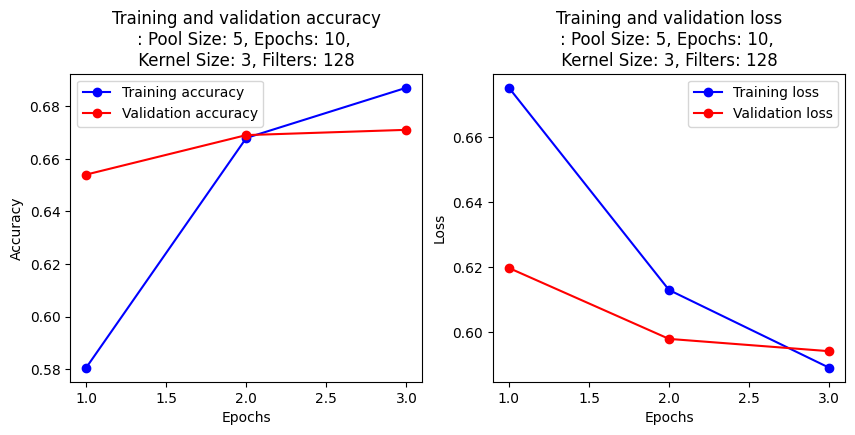



val_loss: 0.5976, val_accuracy: 0.6625


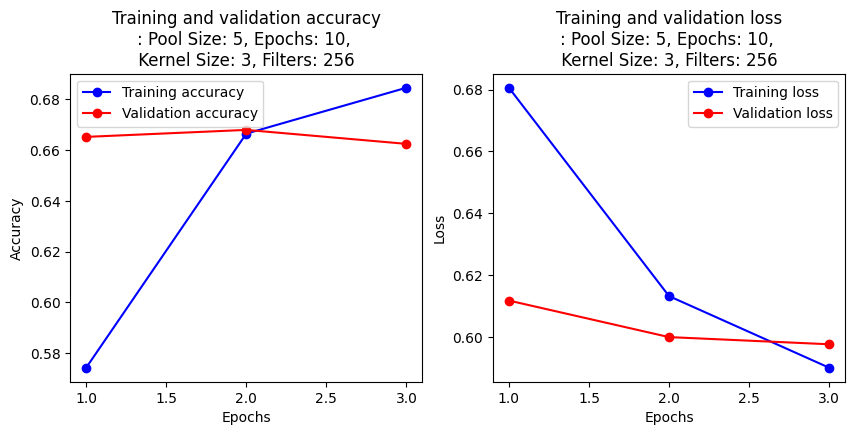



val_loss: 0.5944, val_accuracy: 0.6705


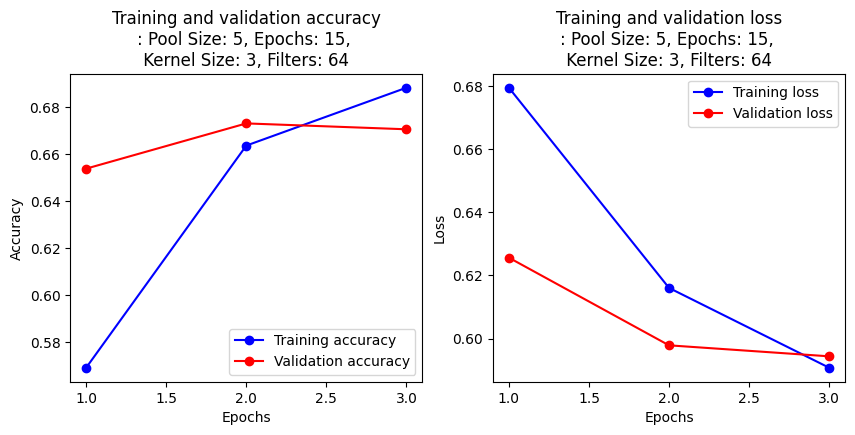



val_loss: 0.5954, val_accuracy: 0.6695


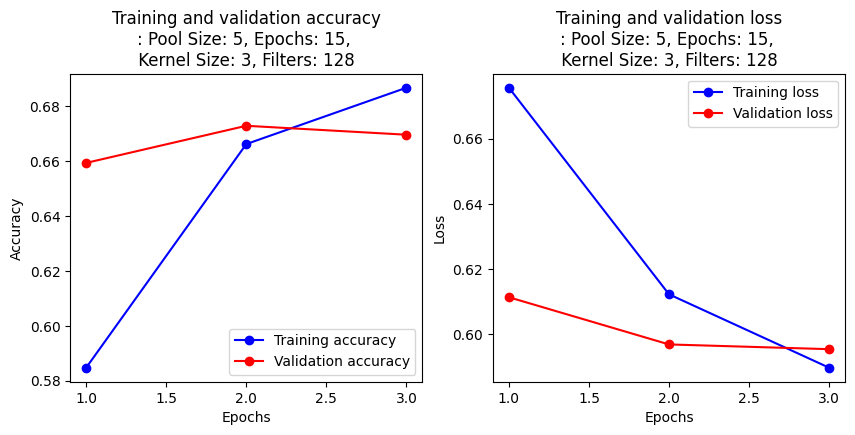



val_loss: 0.5936, val_accuracy: 0.6745


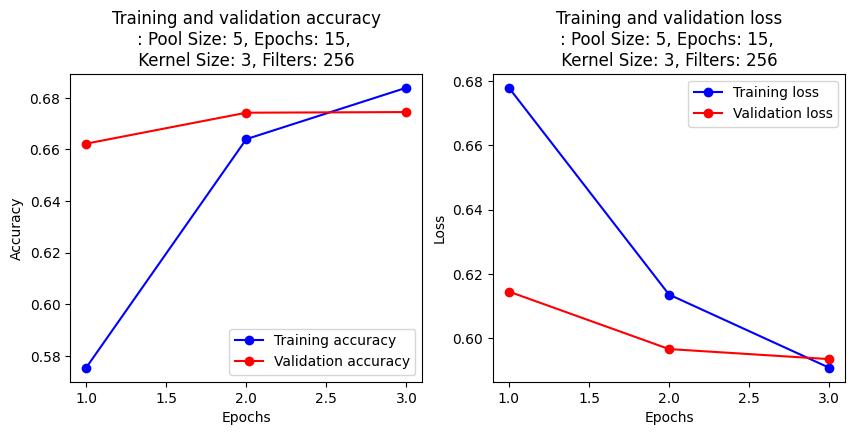



val_loss: 0.5488, val_accuracy: 0.7222


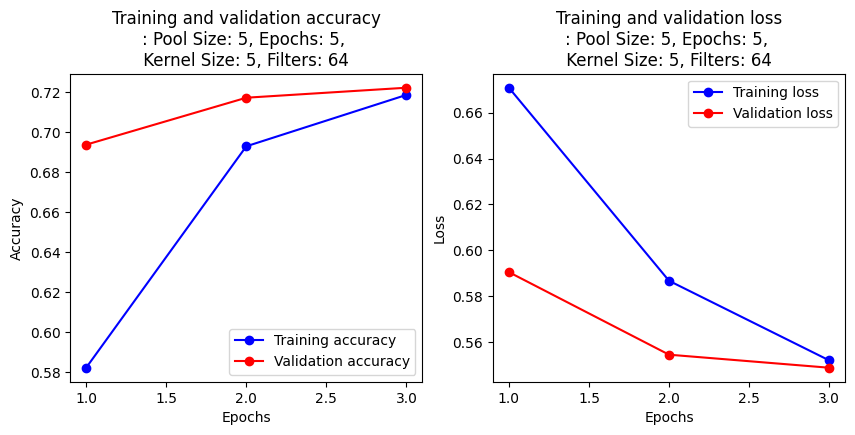



val_loss: 0.5498, val_accuracy: 0.7193


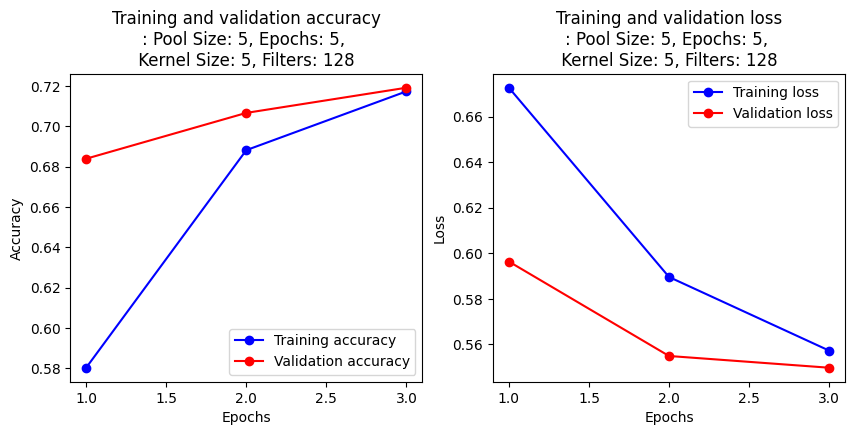



val_loss: 0.5498, val_accuracy: 0.7122


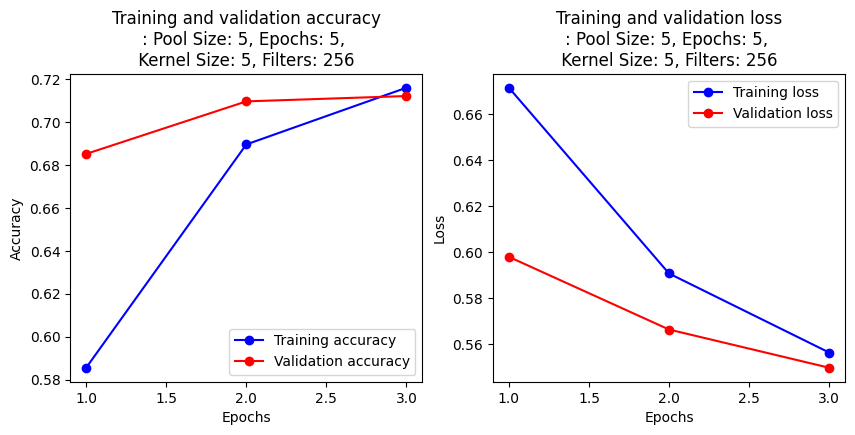



val_loss: 0.5501, val_accuracy: 0.7220


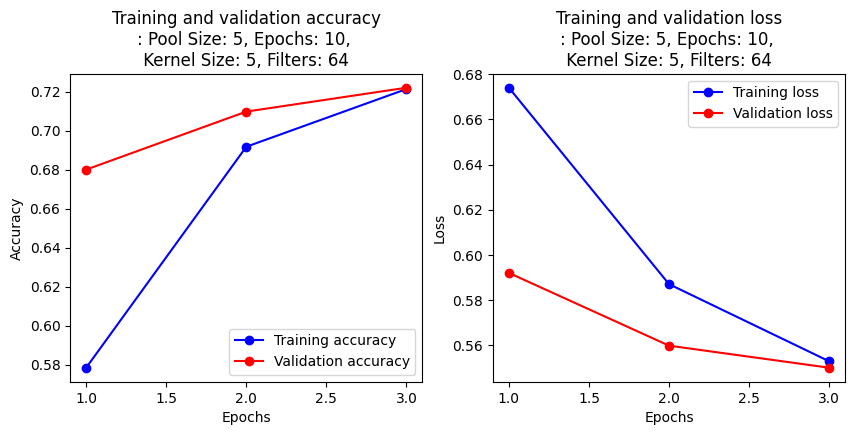



val_loss: 0.5534, val_accuracy: 0.7085


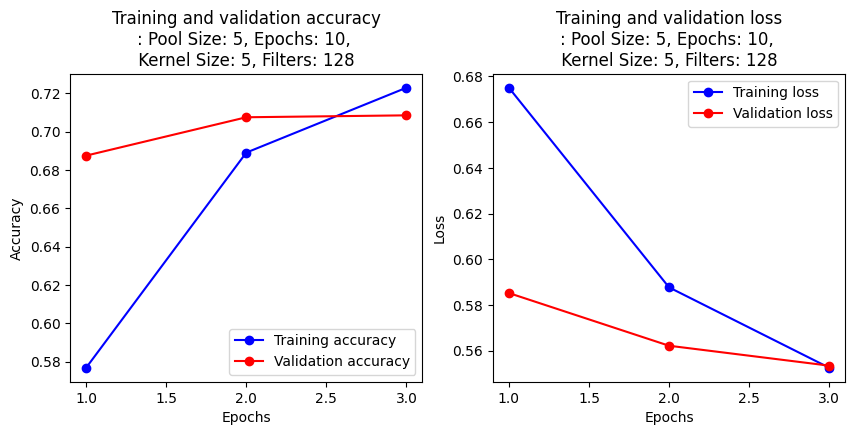



val_loss: 0.5513, val_accuracy: 0.7165


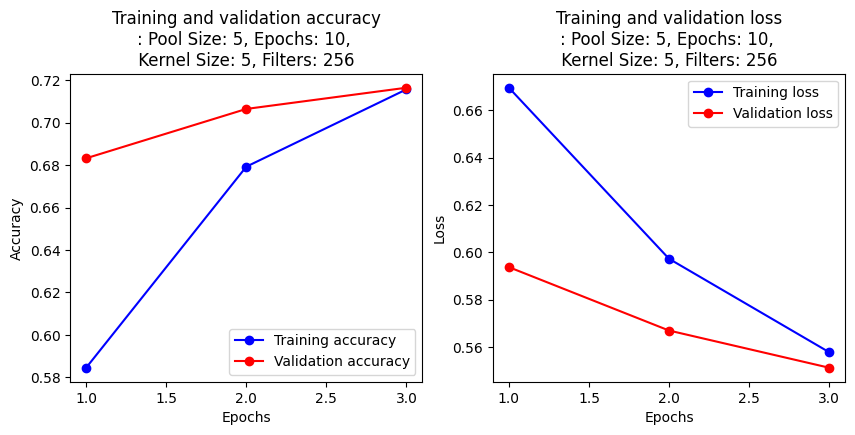



val_loss: 0.5531, val_accuracy: 0.7130


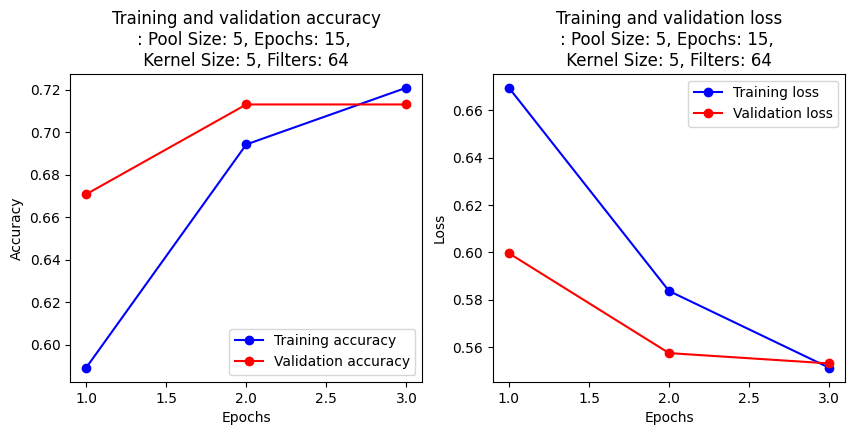



val_loss: 0.5516, val_accuracy: 0.7082


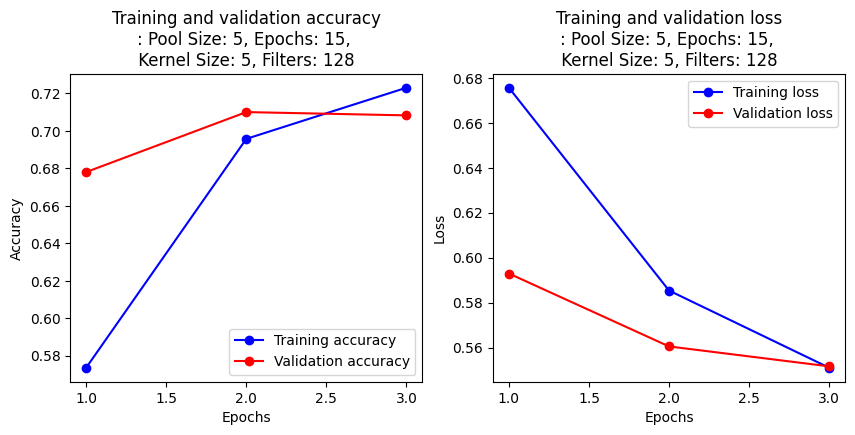



val_loss: 0.5536, val_accuracy: 0.7120


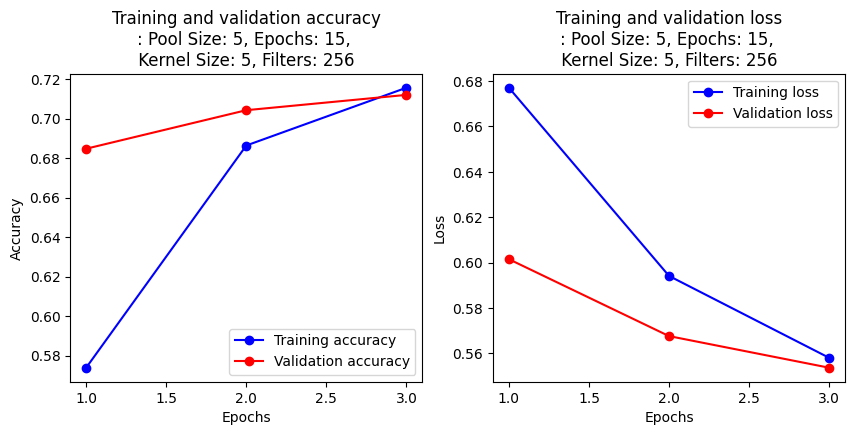



val_loss: 0.6248, val_accuracy: 0.6373


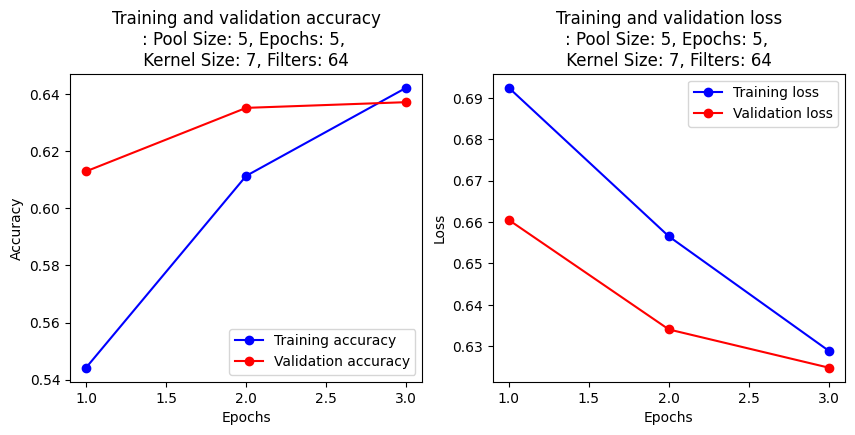



val_loss: 0.6308, val_accuracy: 0.6382


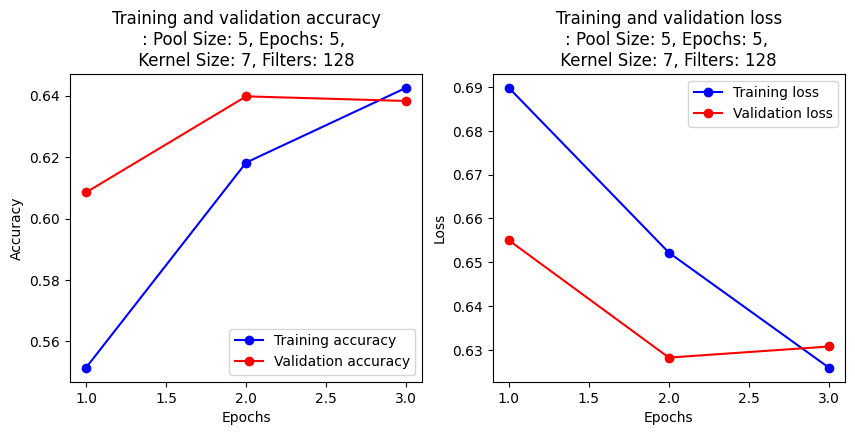



val_loss: 0.6220, val_accuracy: 0.6505


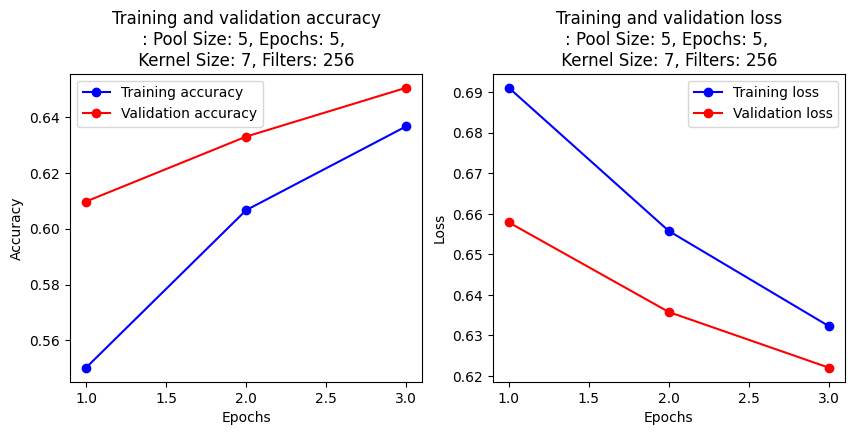



val_loss: 0.6286, val_accuracy: 0.6360


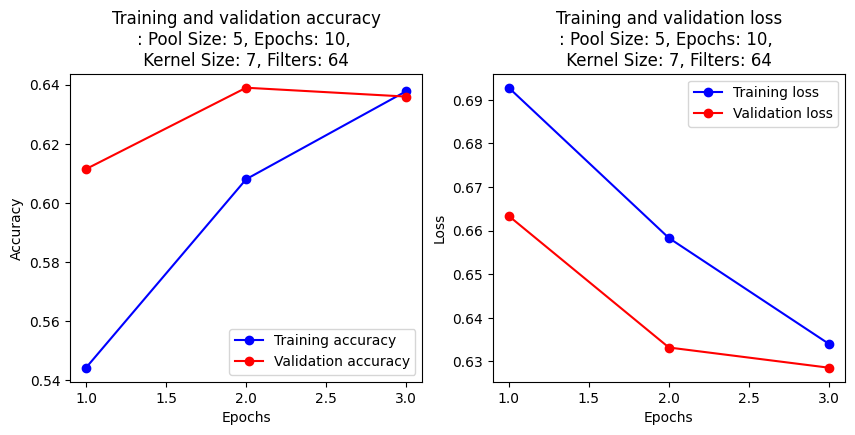



val_loss: 0.6231, val_accuracy: 0.6420


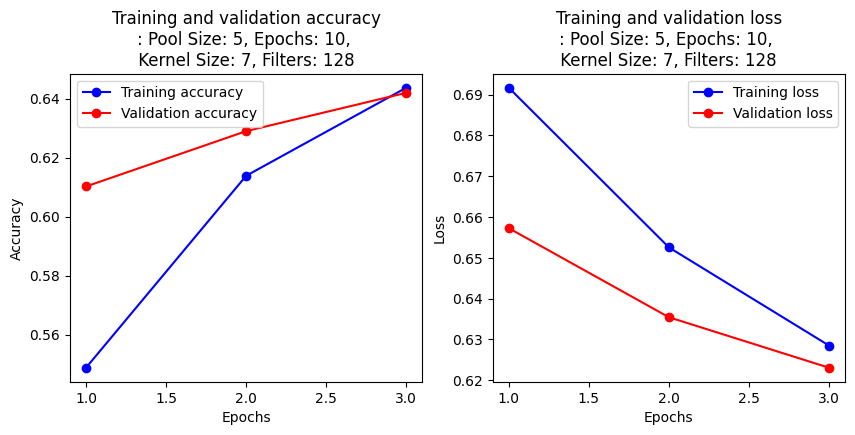



val_loss: 0.6280, val_accuracy: 0.6388


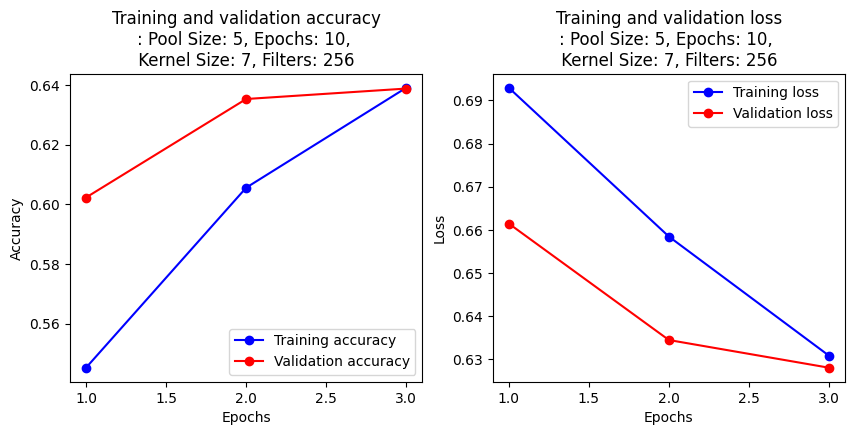



val_loss: 0.6214, val_accuracy: 0.6382


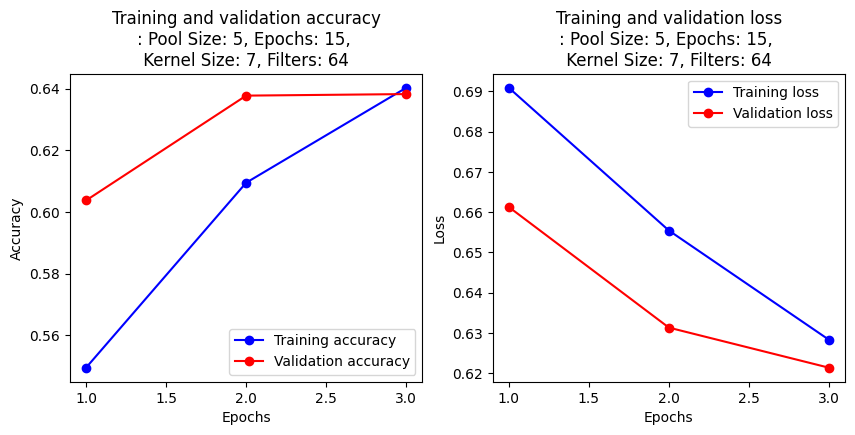



val_loss: 0.6257, val_accuracy: 0.6453


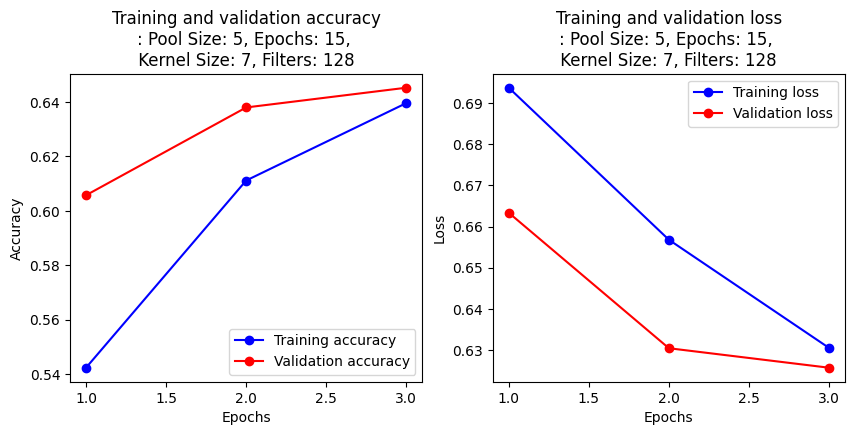



val_loss: 0.6327, val_accuracy: 0.6348


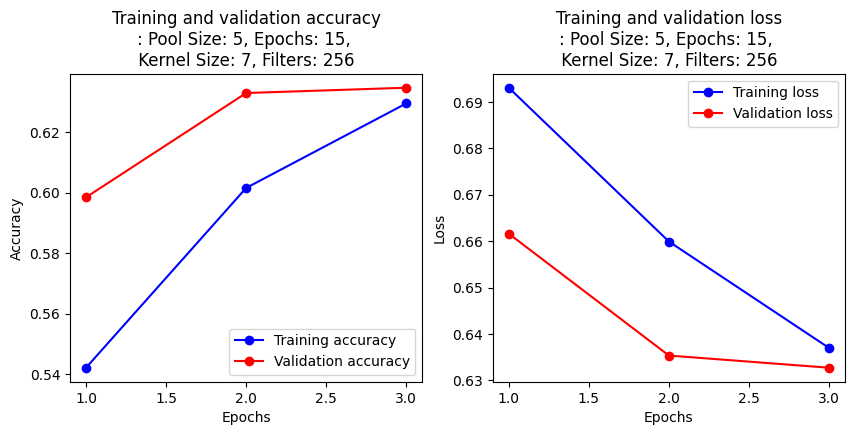



CPU times: user 11min 6s, sys: 25.8 s, total: 11min 31s
Wall time: 14min 22s


In [28]:
%%time
# Fine Hyperparameter tuning
pool_sizes = [2,5]
epochs = [5, 10, 15]
kernel_sizes = [3,5,7]
filters = [64, 128, 256]

for p in pool_sizes:
  for k in kernel_sizes:
    for e in epochs:
      for f in filters:
        cnn_model2 = build_cnn_model2(pool_size=p, embedding_dim=300, kernel_size =k, filters=f)
        cnn_model2_history = cnn_model2.fit(
            x = X_train,
            y = y_train,
            epochs=e,
            batch_size=64,
            validation_data=(X_val, y_val),
            verbose=0,
            callbacks=early_stopping
            )
        val_loss = cnn_model2_history.history['val_loss'][-1]
        val_accuracy = cnn_model2_history.history['val_accuracy'][-1]
        print(f'val_loss: {val_loss:.4f}, val_accuracy: {val_accuracy:.4f}')
        plot_metrics(cnn_model2_history, f'Pool Size: {p}, Epochs: {e}, \n Kernel Size: {k}, Filters: {f} ')
        print('\n')


In [29]:
%%time
# Try Different Pooling Method:
from tensorflow.keras.layers import AveragePooling1D
def build_cnn_model3(pool_size=2, embedding_dim=300, kernel_size =7, filters=128):
    tf.keras.backend.clear_session()
    tf.random.set_seed(0)

    cnn_model = Sequential()
    cnn_model.add(tf.keras.layers.Input(shape=(100,)))
    cnn_model.add(Embedding(input_dim=4000,
                            output_dim=embedding_dim,
                            weights=[embedding_matrix],
                            input_length=100,
                            trainable=False))
    cnn_model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    cnn_model.add(AveragePooling1D(pool_size=pool_size))
    cnn_model.add(Flatten())
    cnn_model.add(Dense(128, activation='relu'))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(64, activation='relu'))
    cnn_model.add(Dropout(0.5))
    cnn_model.add(Dense(2, activation='sigmoid'))

    cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn_model

CPU times: user 15 µs, sys: 0 ns, total: 15 µs
Wall time: 18.8 µs


val_loss: 0.5060, val_accuracy: 0.7580


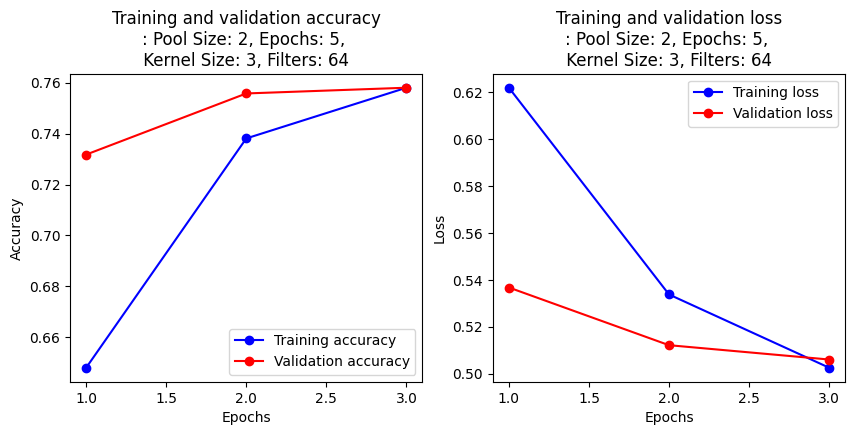



val_loss: 0.5040, val_accuracy: 0.7567


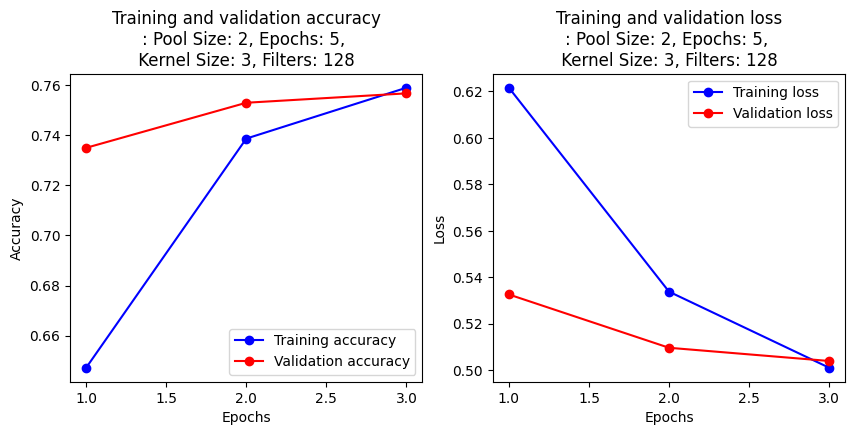



val_loss: 0.5145, val_accuracy: 0.7548


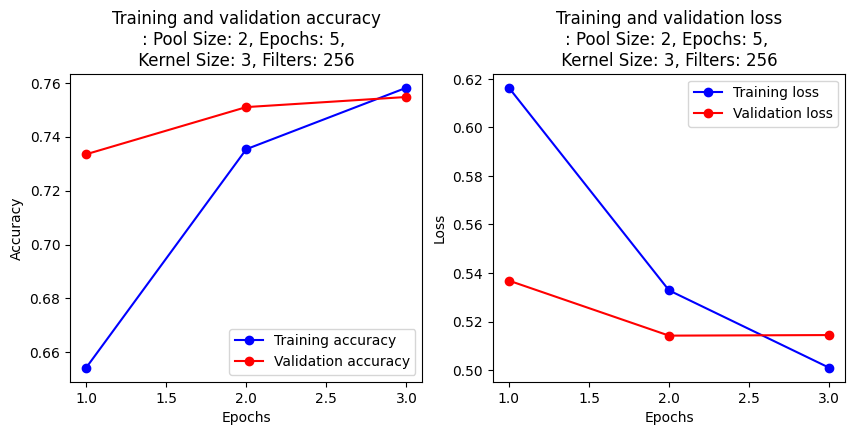



val_loss: 0.5030, val_accuracy: 0.7545


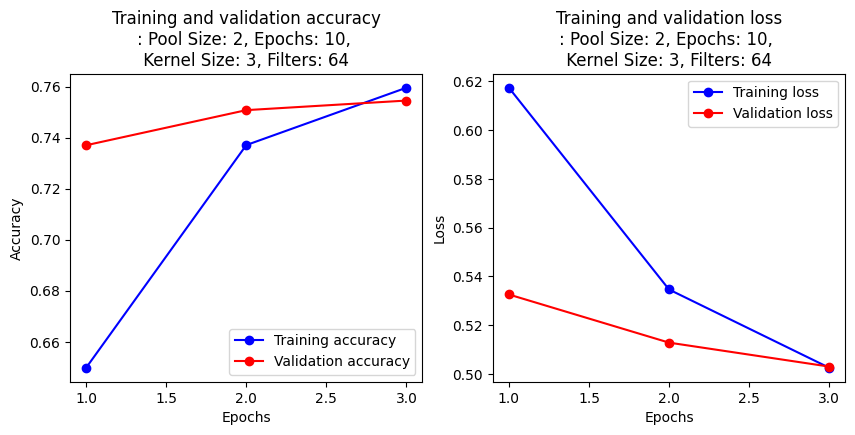



val_loss: 0.5114, val_accuracy: 0.7467


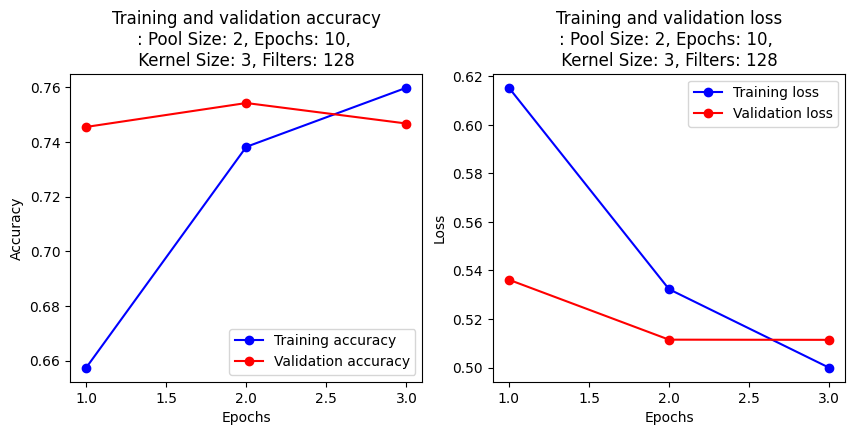



val_loss: 0.5046, val_accuracy: 0.7555


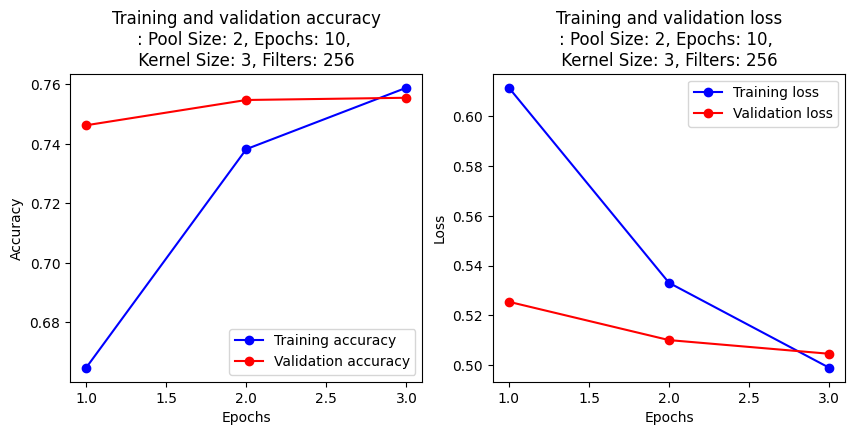



val_loss: 0.5036, val_accuracy: 0.7615


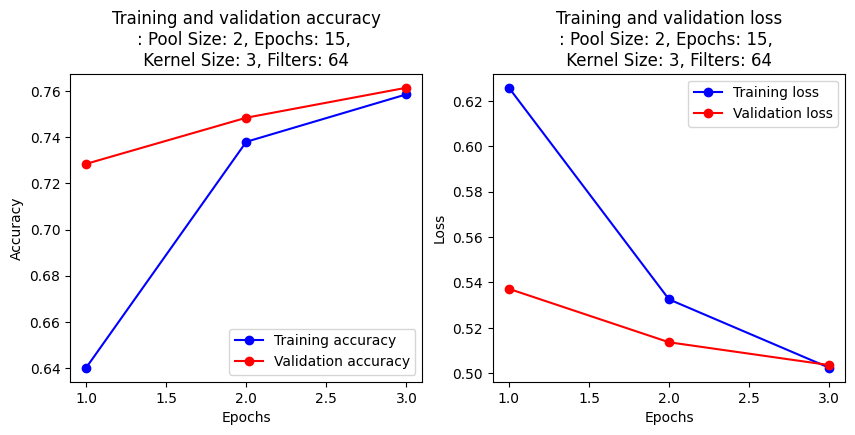



val_loss: 0.5056, val_accuracy: 0.7570


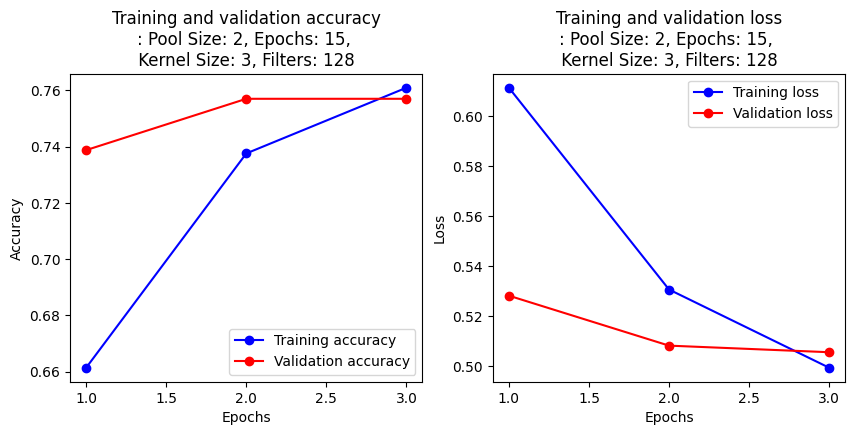



val_loss: 0.5130, val_accuracy: 0.7508


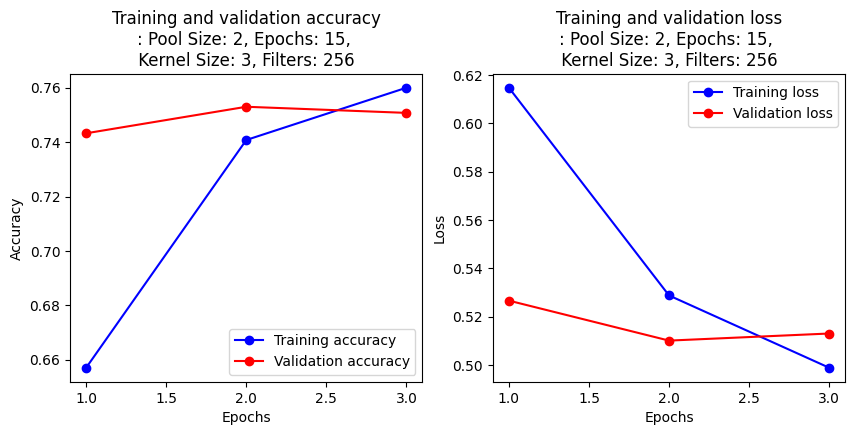



val_loss: 0.5140, val_accuracy: 0.7535


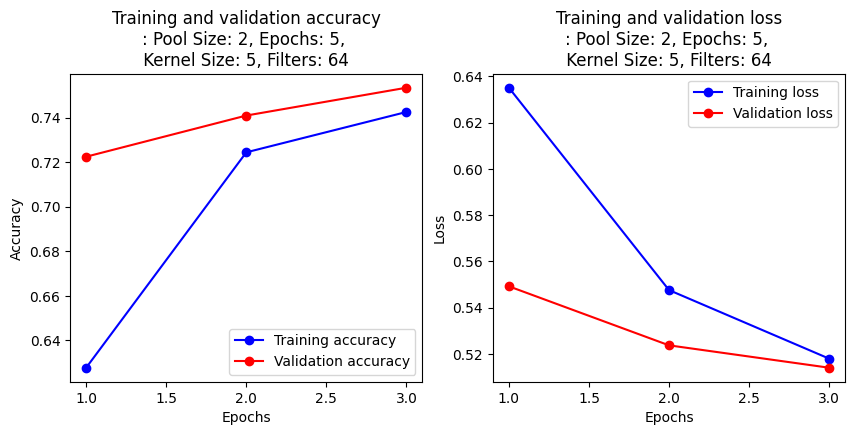



val_loss: 0.5154, val_accuracy: 0.7513


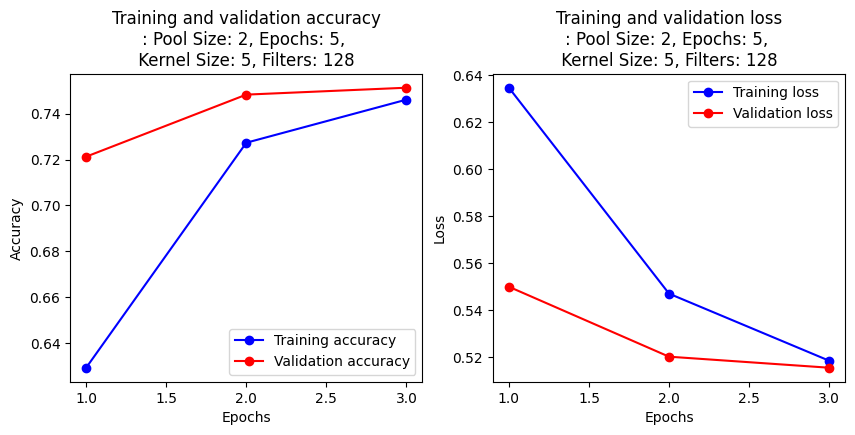



val_loss: 0.5218, val_accuracy: 0.7460


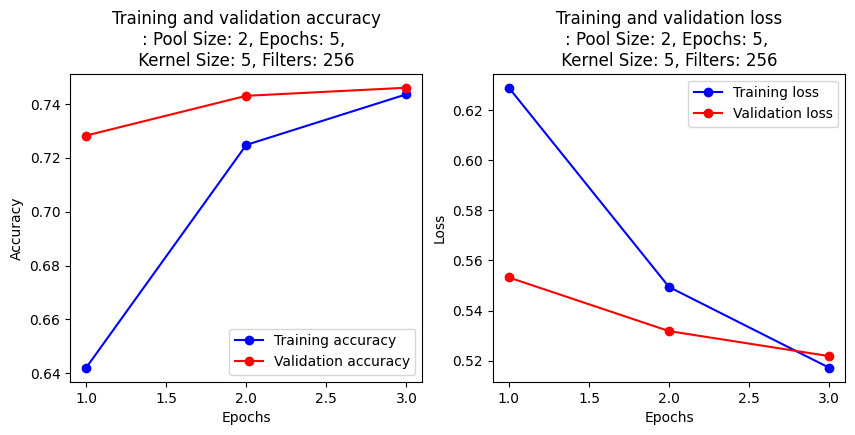



val_loss: 0.5167, val_accuracy: 0.7510


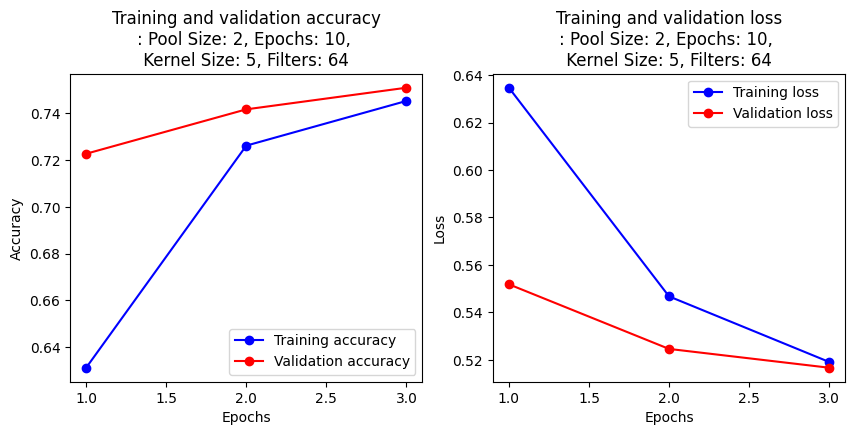



val_loss: 0.5150, val_accuracy: 0.7530


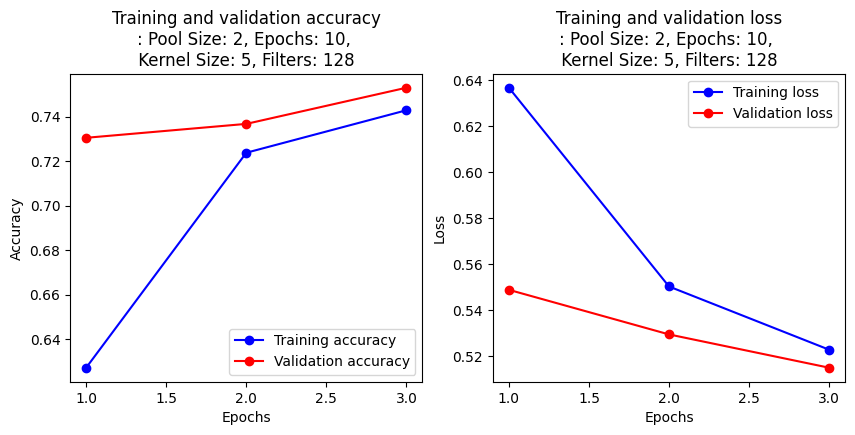



val_loss: 0.5219, val_accuracy: 0.7455


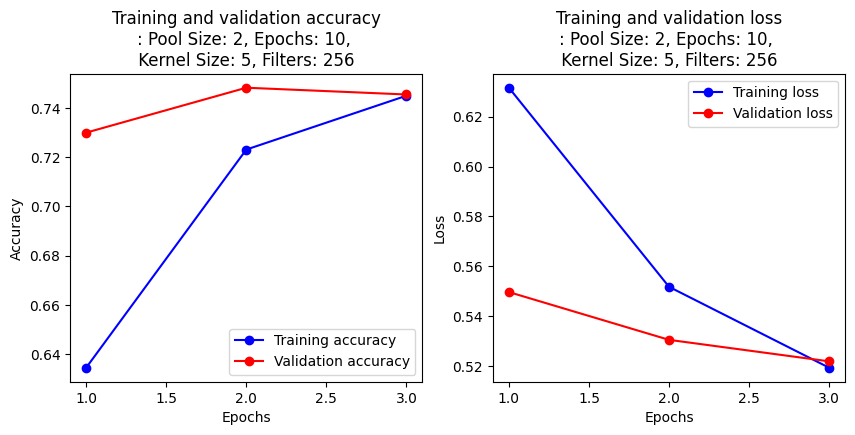



val_loss: 0.5137, val_accuracy: 0.7535


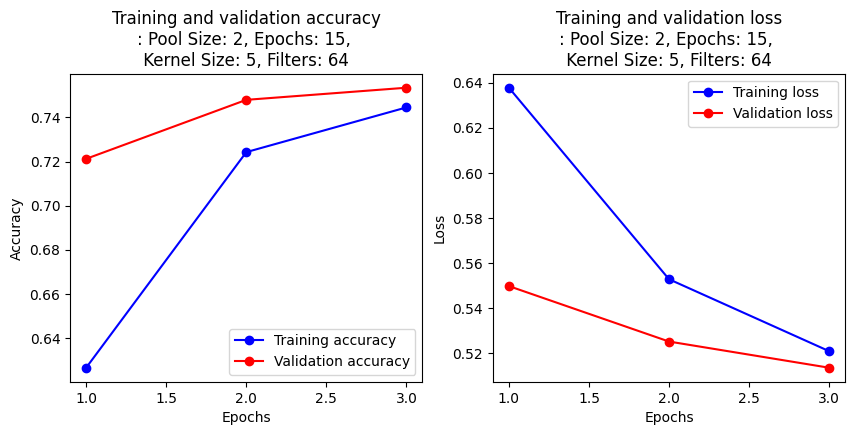



val_loss: 0.5169, val_accuracy: 0.7545


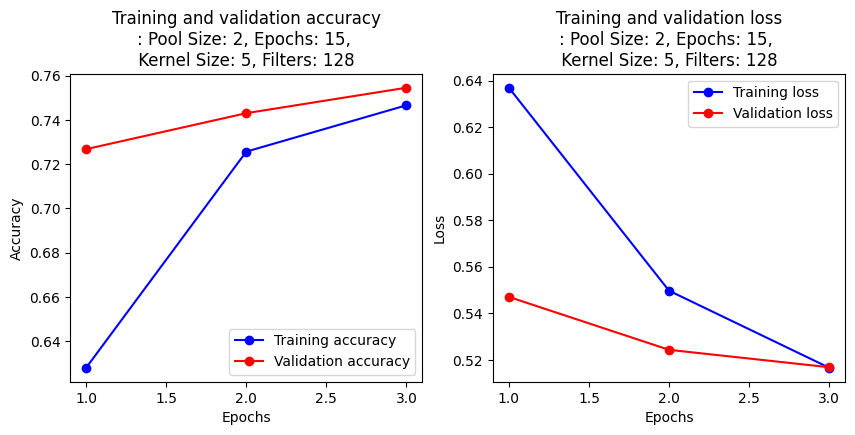



val_loss: 0.5136, val_accuracy: 0.7500


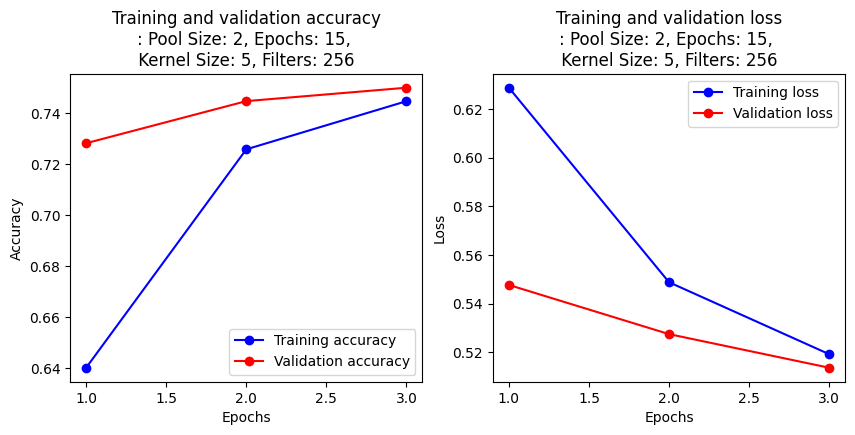



val_loss: 0.5181, val_accuracy: 0.7470


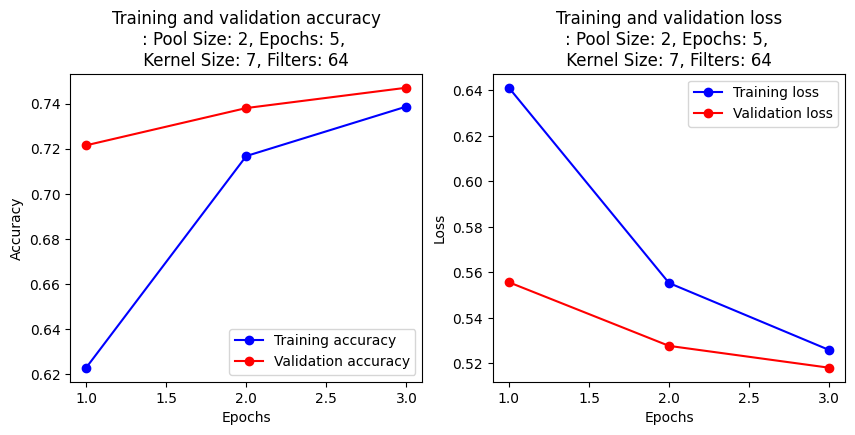



val_loss: 0.5224, val_accuracy: 0.7430


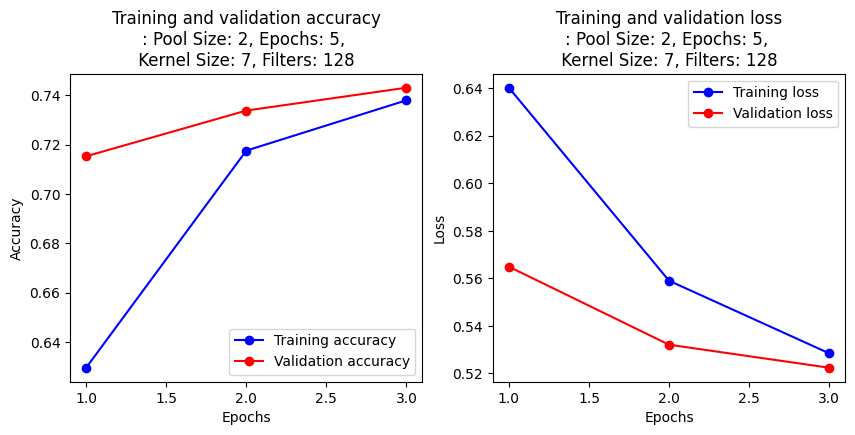



val_loss: 0.5221, val_accuracy: 0.7450


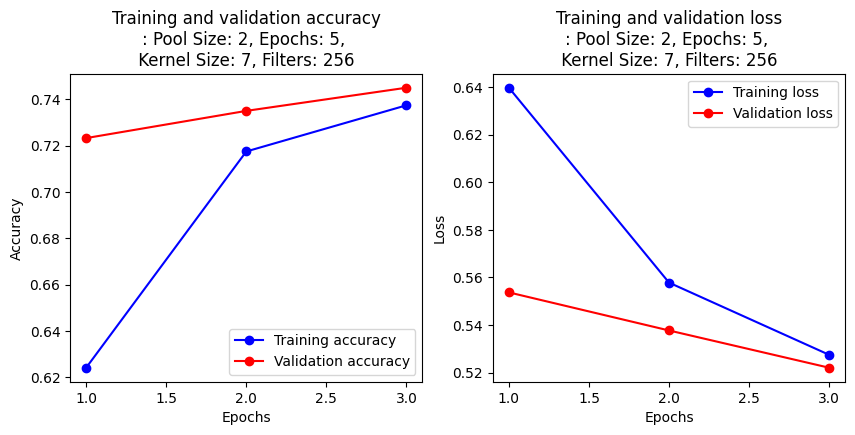



val_loss: 0.5204, val_accuracy: 0.7427


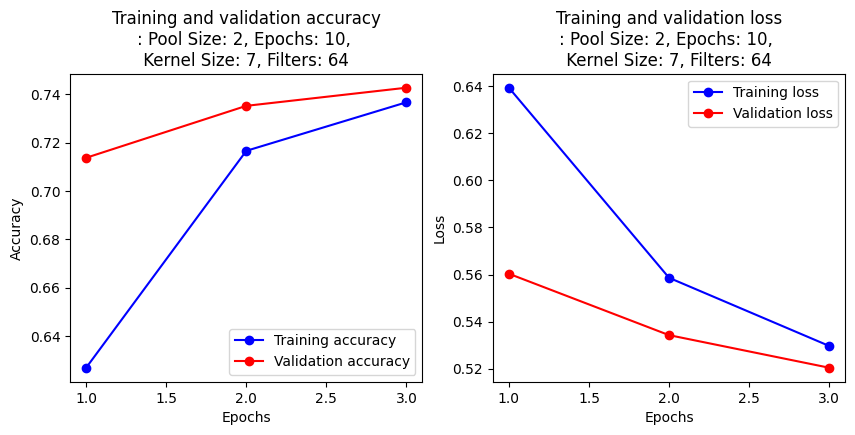



val_loss: 0.5248, val_accuracy: 0.7405


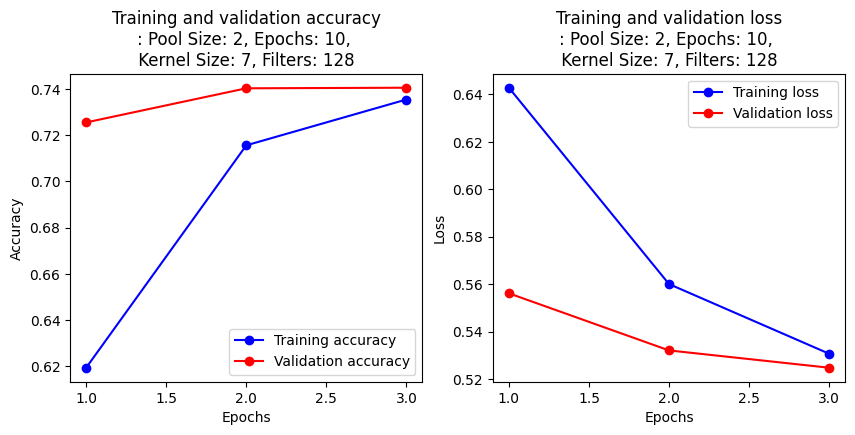



val_loss: 0.5167, val_accuracy: 0.7462


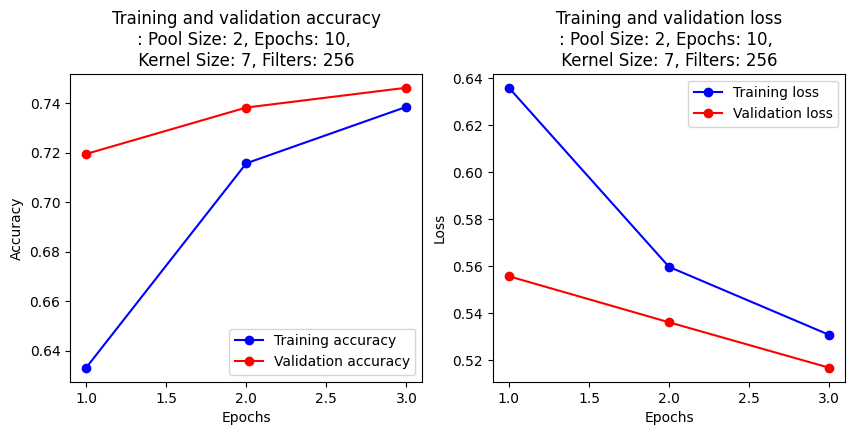



val_loss: 0.5249, val_accuracy: 0.7435


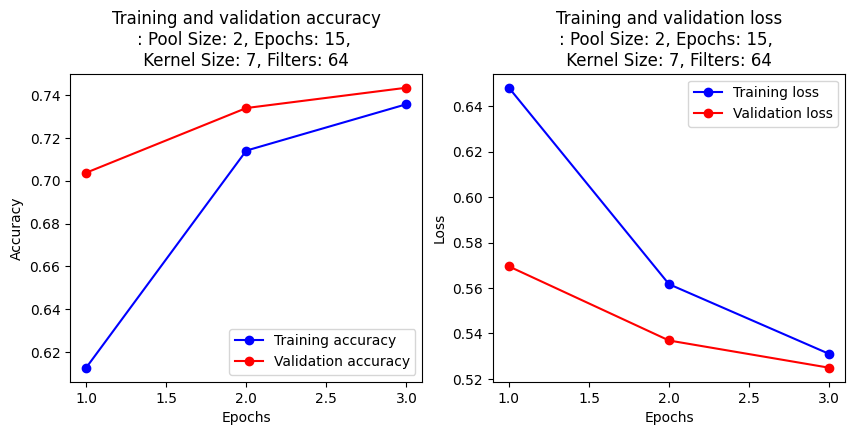



val_loss: 0.5218, val_accuracy: 0.7385


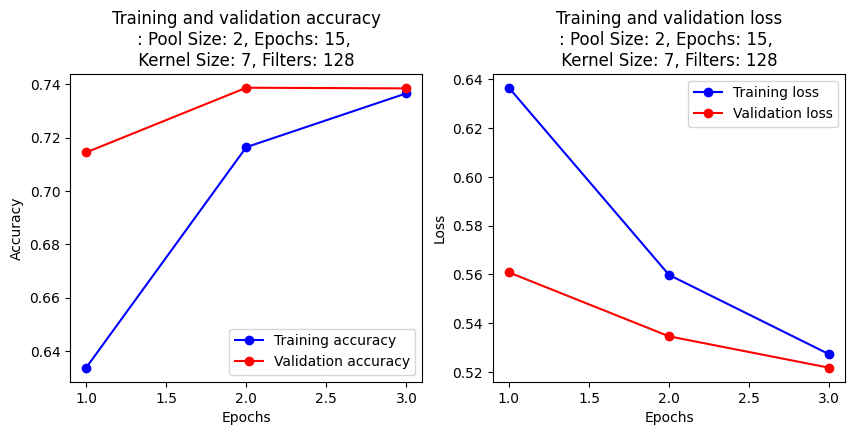



val_loss: 0.5255, val_accuracy: 0.7370


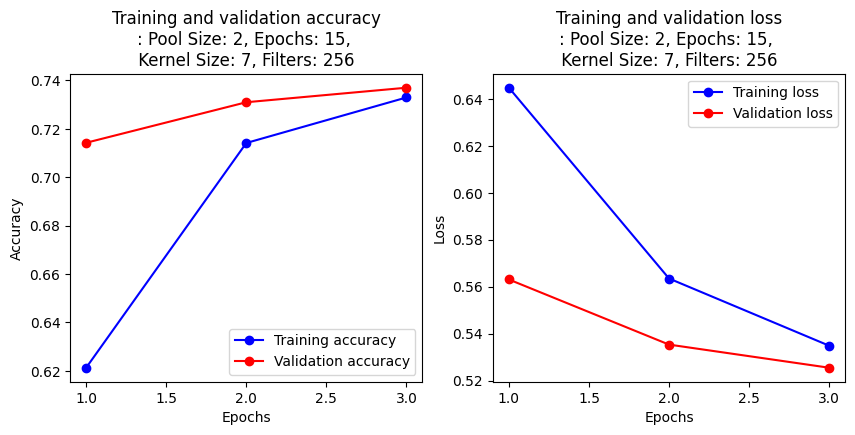



val_loss: 0.5954, val_accuracy: 0.6740


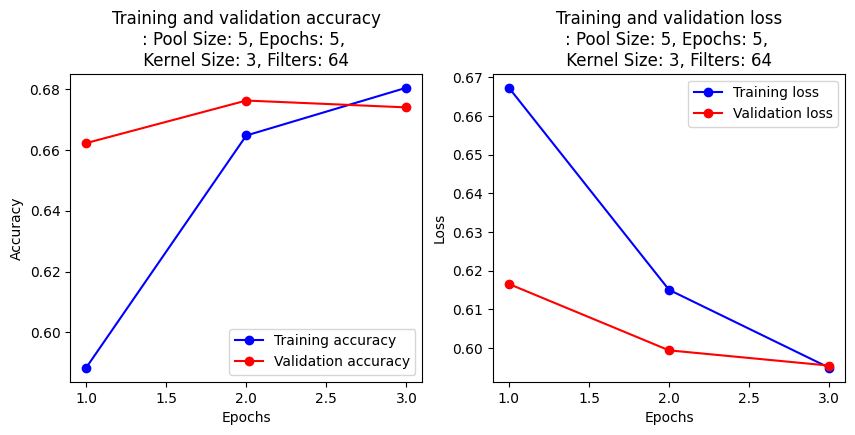



val_loss: 0.5975, val_accuracy: 0.6718


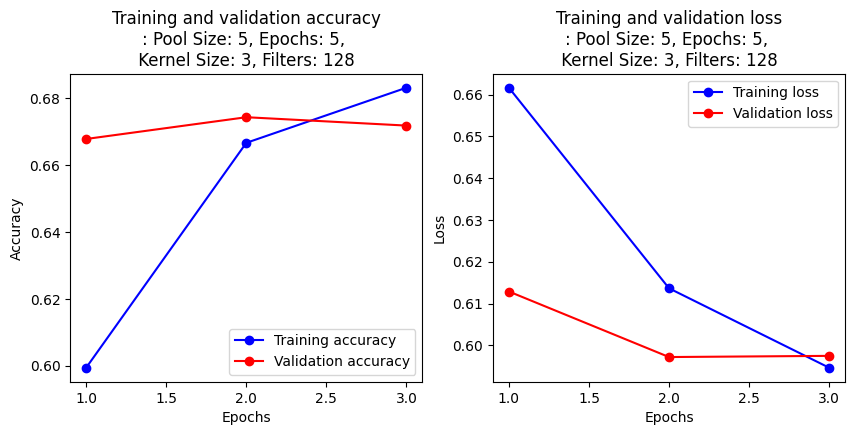



val_loss: 0.5936, val_accuracy: 0.6737


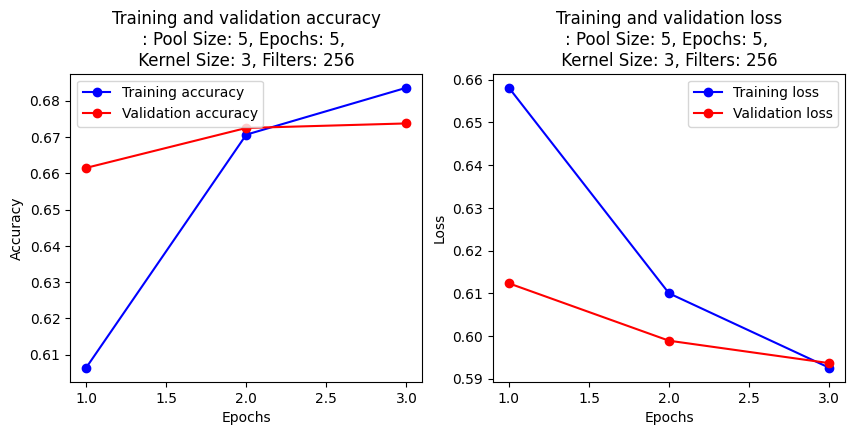



val_loss: 0.5957, val_accuracy: 0.6758


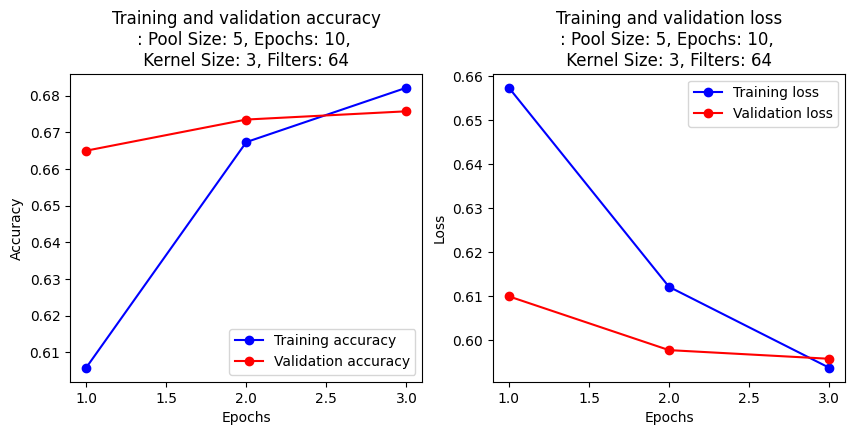



val_loss: 0.5965, val_accuracy: 0.6802


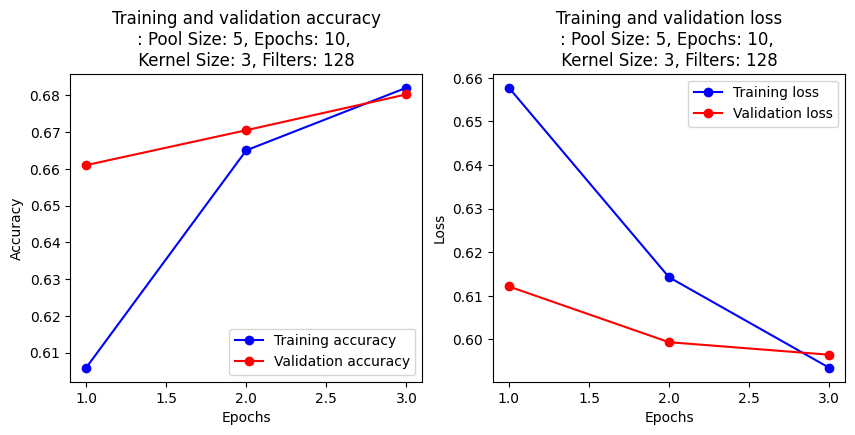



val_loss: 0.5948, val_accuracy: 0.6802


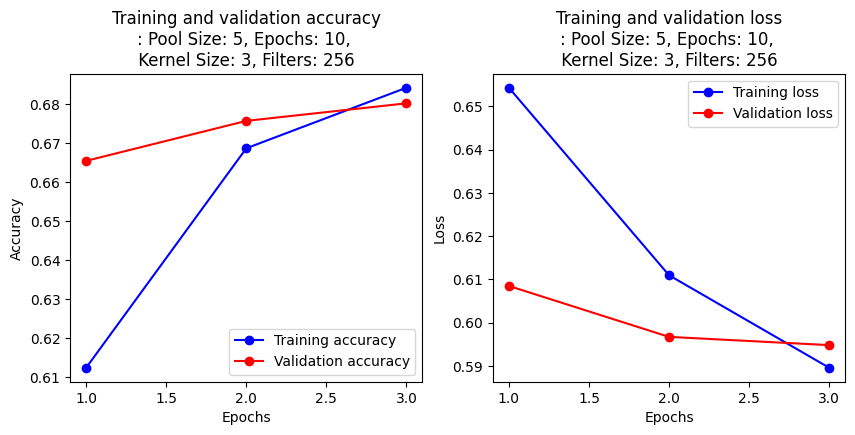



val_loss: 0.5960, val_accuracy: 0.6750


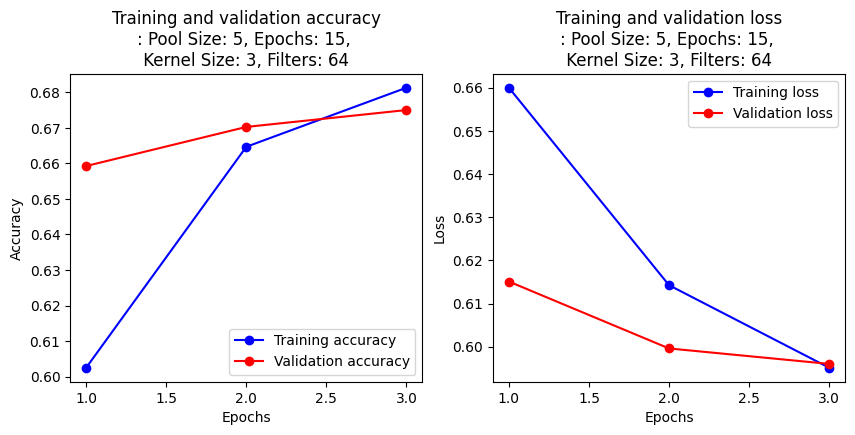



val_loss: 0.5937, val_accuracy: 0.6747


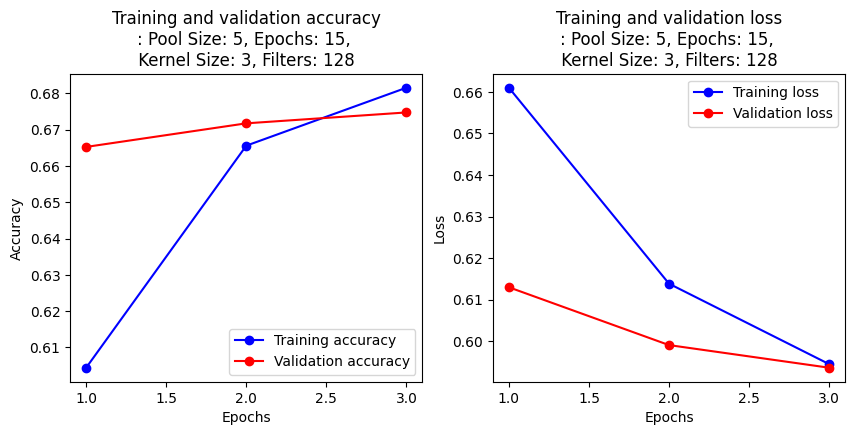



val_loss: 0.5959, val_accuracy: 0.6765


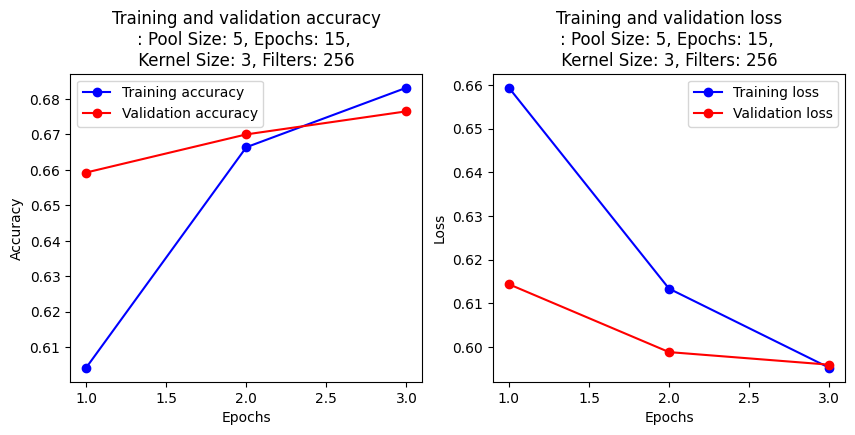



val_loss: 0.5553, val_accuracy: 0.7165


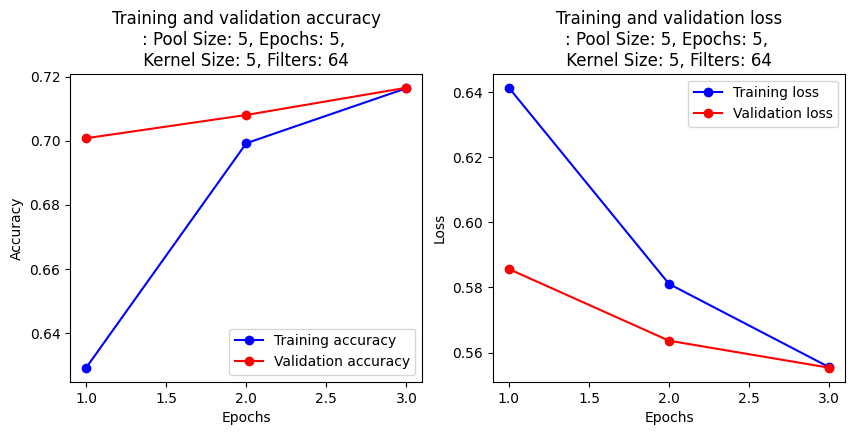



val_loss: 0.5533, val_accuracy: 0.7072


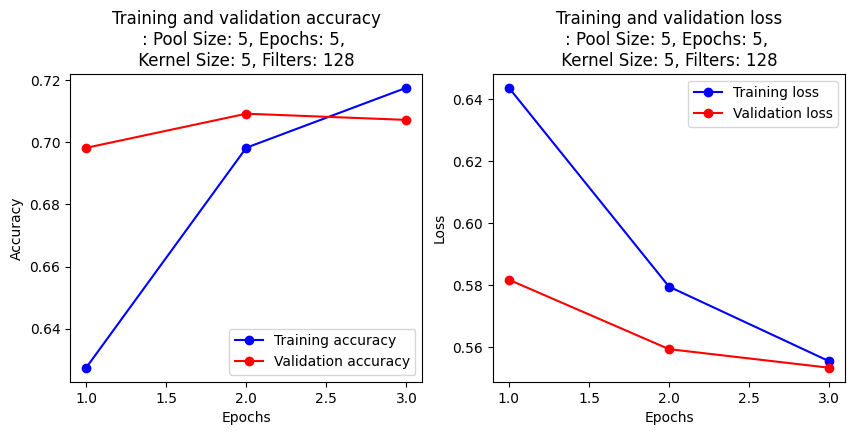



val_loss: 0.5546, val_accuracy: 0.7168


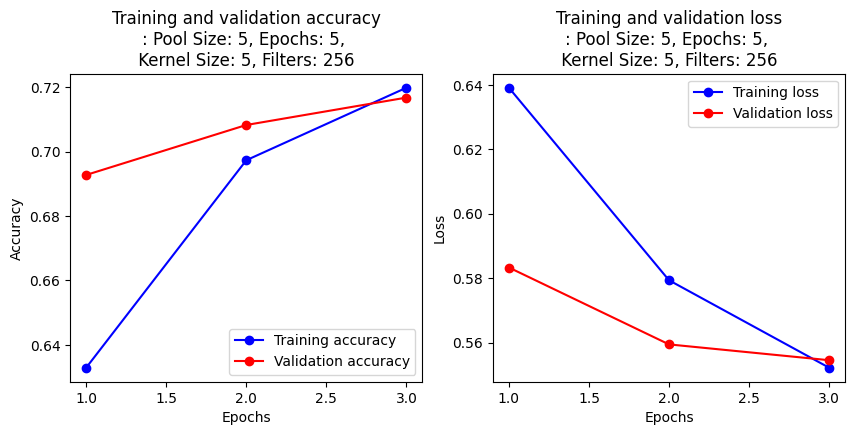



val_loss: 0.5517, val_accuracy: 0.7150


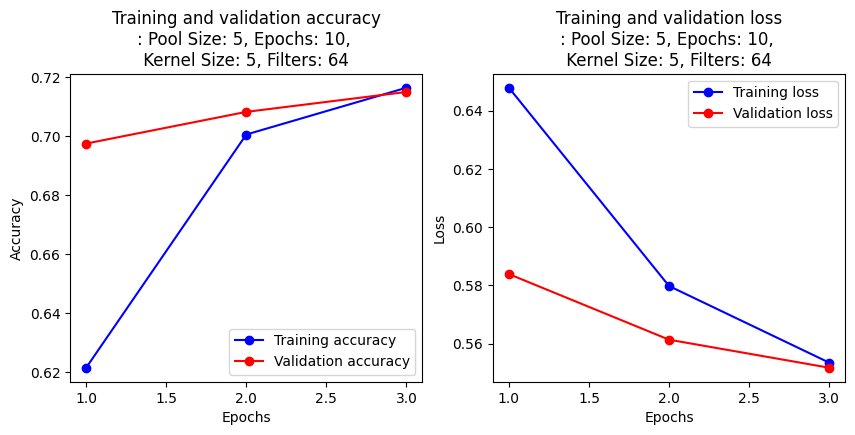



val_loss: 0.5490, val_accuracy: 0.7180


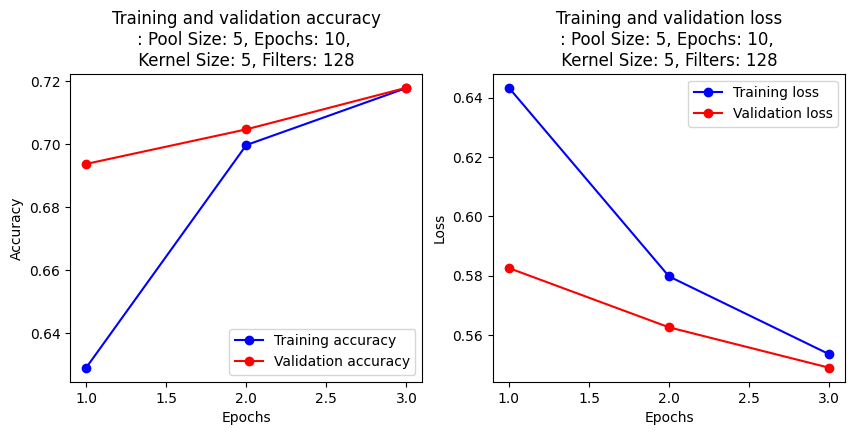



val_loss: 0.5554, val_accuracy: 0.7115


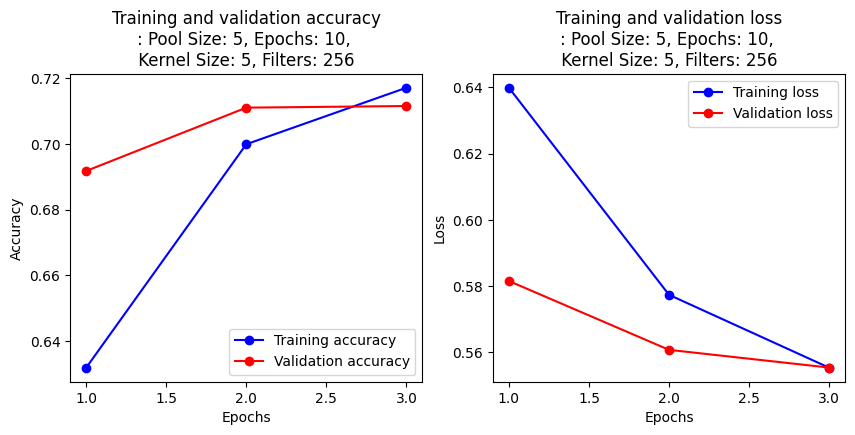



val_loss: 0.5563, val_accuracy: 0.7170


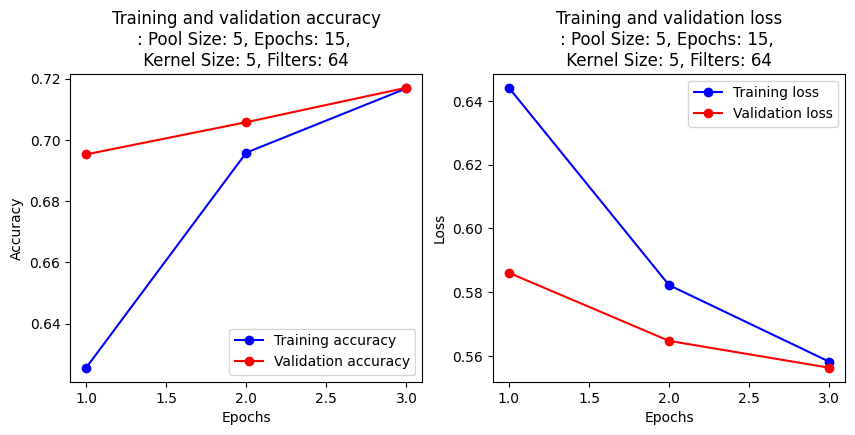



val_loss: 0.5513, val_accuracy: 0.7157


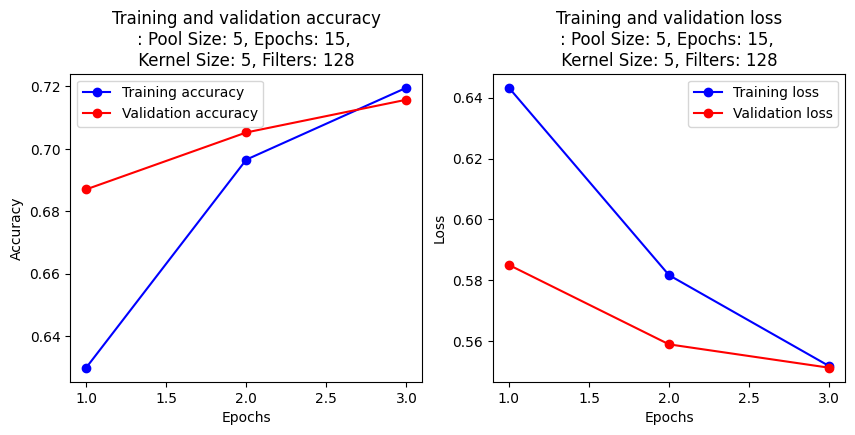



val_loss: 0.5531, val_accuracy: 0.7182


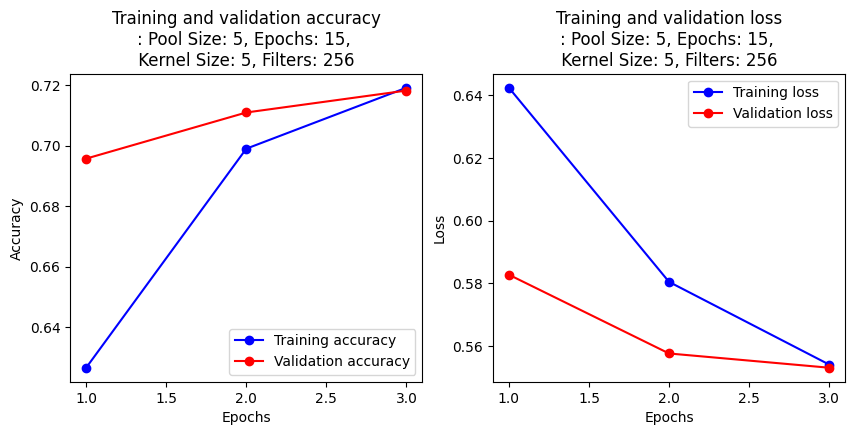



val_loss: 0.6252, val_accuracy: 0.6525


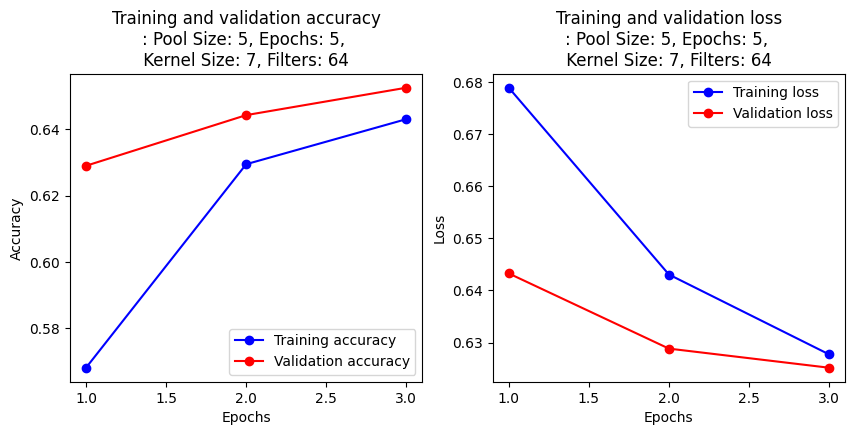



val_loss: 0.6216, val_accuracy: 0.6445


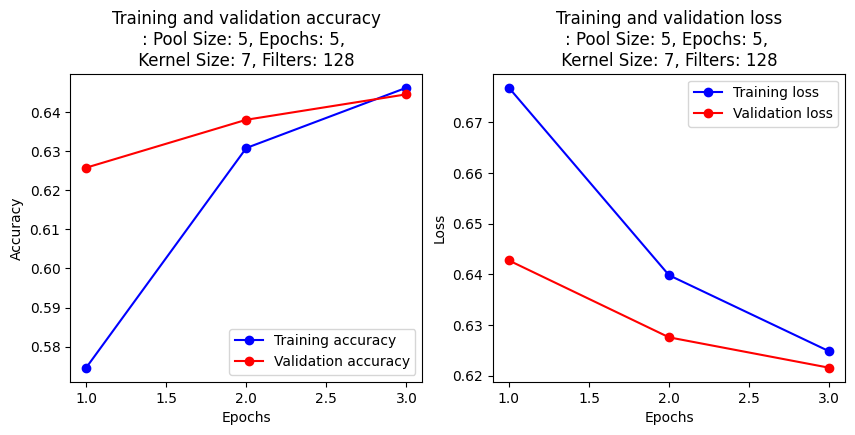



val_loss: 0.6212, val_accuracy: 0.6505


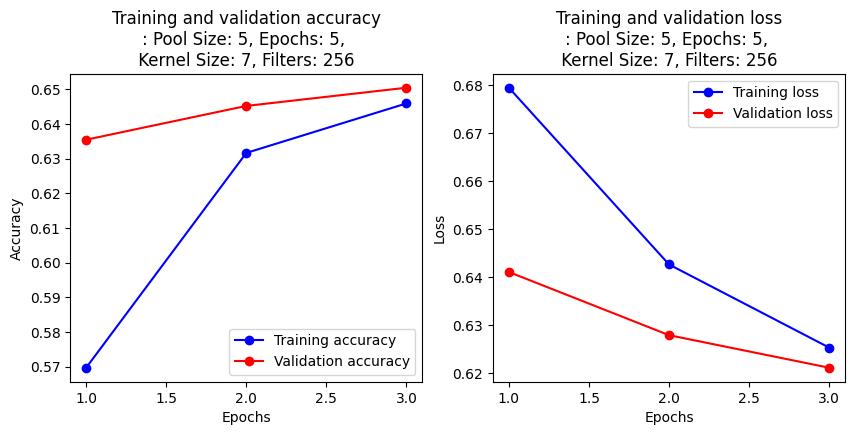



val_loss: 0.6272, val_accuracy: 0.6472


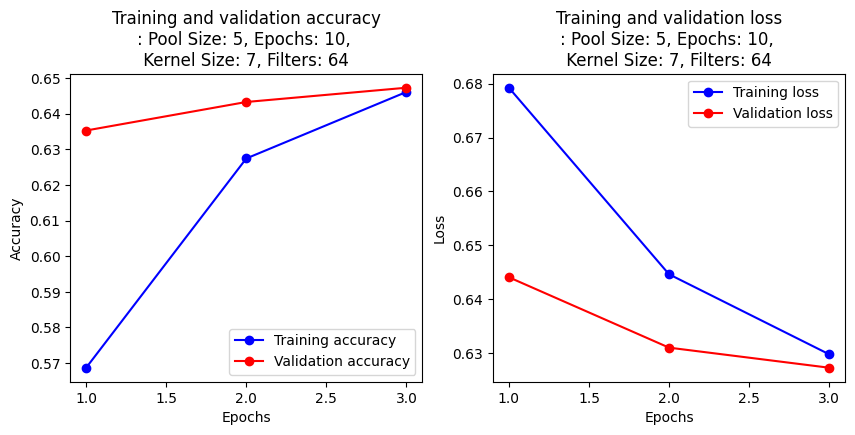



val_loss: 0.6222, val_accuracy: 0.6503


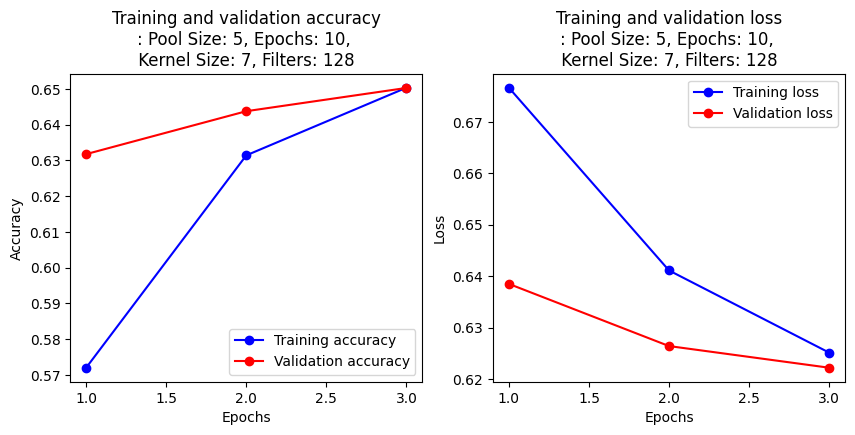



val_loss: 0.6213, val_accuracy: 0.6482


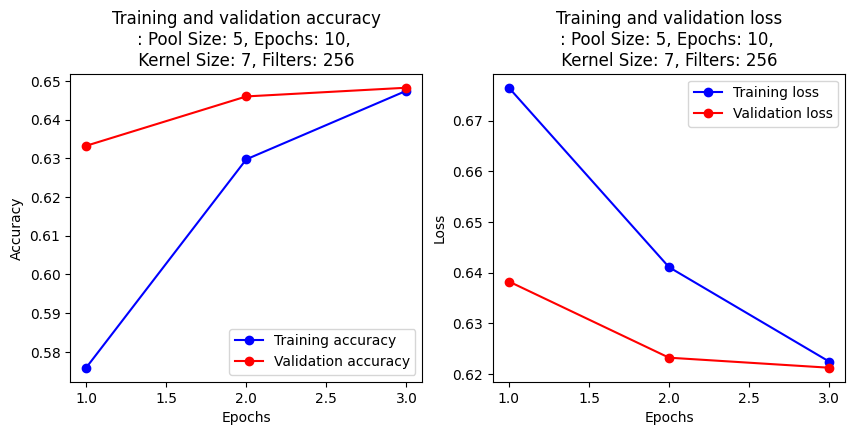



val_loss: 0.6213, val_accuracy: 0.6513


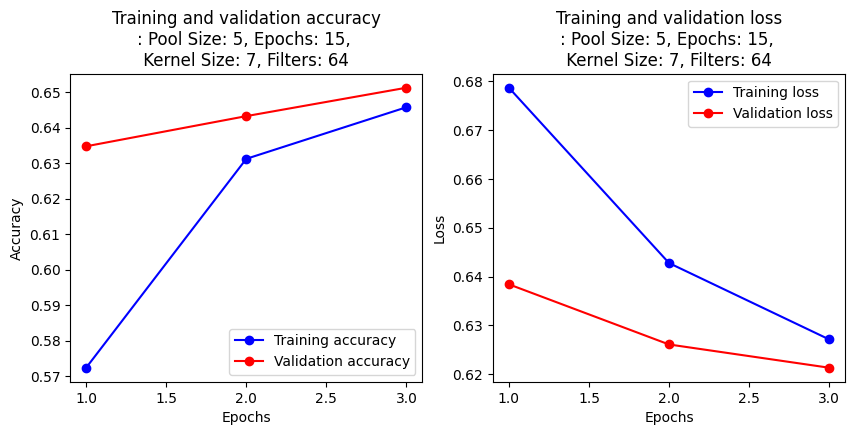



val_loss: 0.6214, val_accuracy: 0.6480


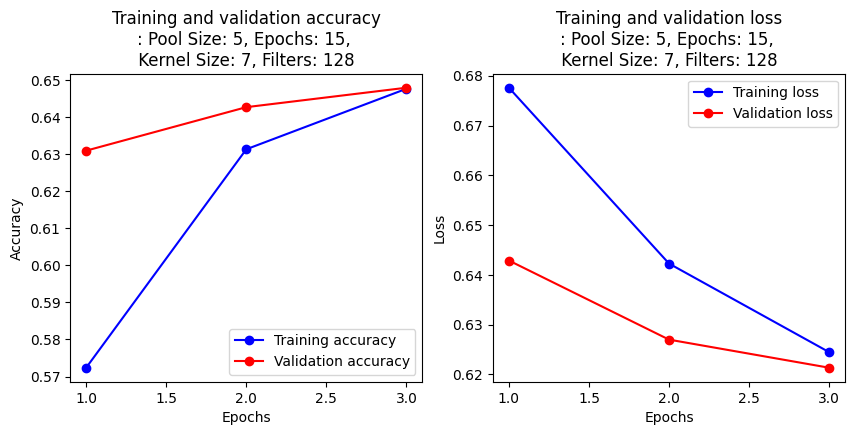



val_loss: 0.6201, val_accuracy: 0.6513


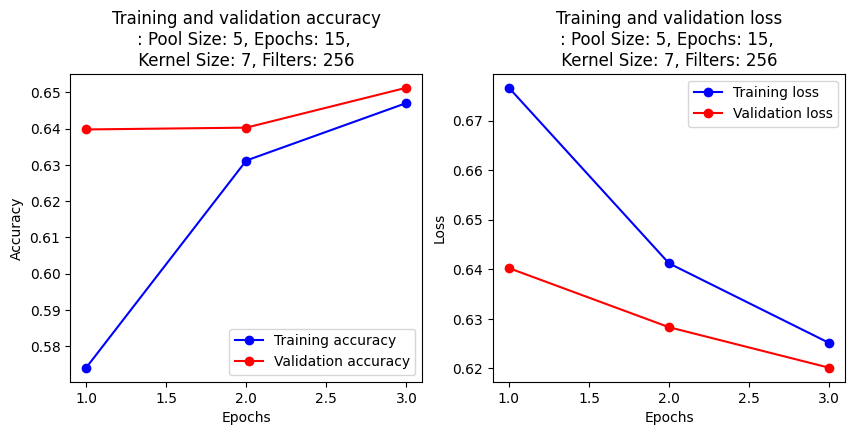



CPU times: user 10min 46s, sys: 23.2 s, total: 11min 9s
Wall time: 12min 48s


In [30]:
%%time
# Fine Hyperparameter tuning - Average Pooling Model
pool_sizes = [2,5]
epochs = [5, 10, 15]
kernel_sizes = [3,5,7]
filters = [64, 128, 256]

for p in pool_sizes:
  for k in kernel_sizes:
    for e in epochs:
      for f in filters:
        cnn_model3 = build_cnn_model3(pool_size=p, embedding_dim=300, kernel_size =k, filters=f)
        cnn_model3_history = cnn_model3.fit(
            x = X_train,
            y = y_train,
            epochs=e,
            batch_size=64,
            validation_data=(X_val, y_val),
            verbose=0,
            callbacks=early_stopping
            )
        val_loss = cnn_model3_history.history['val_loss'][-1]
        val_accuracy = cnn_model3_history.history['val_accuracy'][-1]
        print(f'val_loss: {val_loss:.4f}, val_accuracy: {val_accuracy:.4f}')
        plot_metrics(cnn_model3_history, f'Pool Size: {p}, Epochs: {e}, \n Kernel Size: {k}, Filters: {f} ')
        print('\n')


In [31]:
# The final improved cnn model: Max Pooling Method, pool size: 2, epochs = 5, kernel_size = 5, filter = 128
cnn_model2 = build_cnn_model2(pool_size = 2, kernel_size=5, filters=128)
cnn_history2 = cnn_model2.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val), callbacks=early_stopping)

cnn_score2, cnn_acc2 = cnn_model2.evaluate(X_test, y_test, batch_size=64)
print('CNN Model Test accuracy:', cnn_acc2)

Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.5653 - loss: 0.6822 - val_accuracy: 0.7308 - val_loss: 0.5469
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7224 - loss: 0.5552 - val_accuracy: 0.7455 - val_loss: 0.5281
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7439 - loss: 0.5222 - val_accuracy: 0.7490 - val_loss: 0.5151
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7454 - loss: 0.5134
CNN Model Test accuracy: 0.734499990940094


### 📊Plotting

### Metrics Plot

In [32]:
# Plotting function
def plot_metrics(history, title):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 4))

    # Plotting accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc, 'ro-', label='Validation accuracy')
    plt.title(f'Training and validation accuracy\n: {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo-', label='Training loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
    plt.title(f'Training and validation loss\n: {title}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


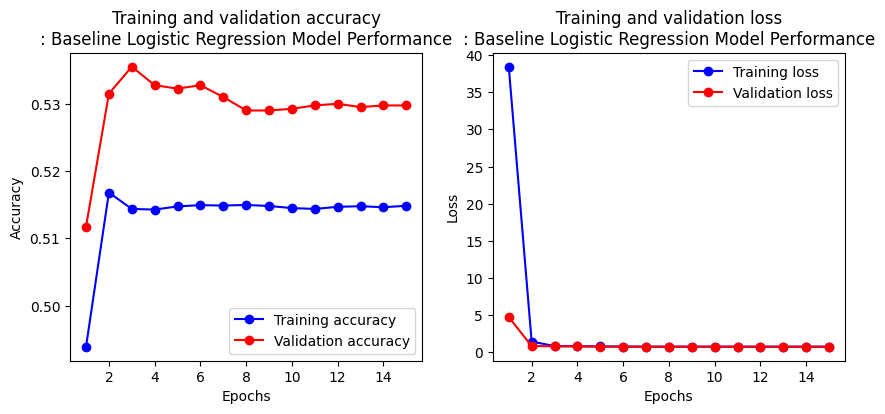

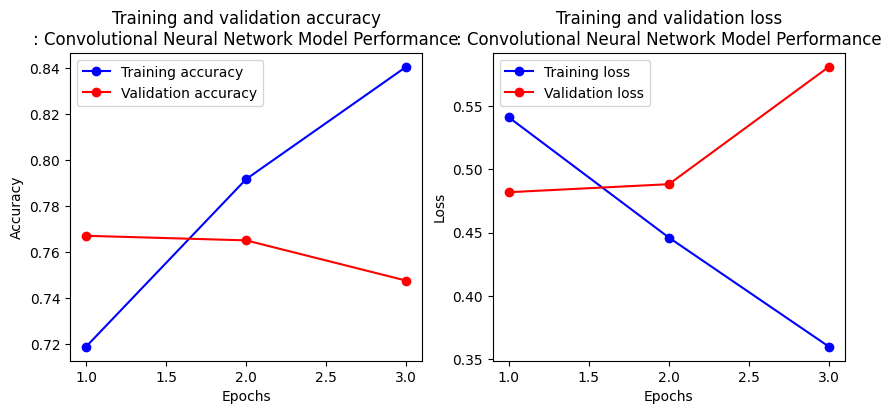

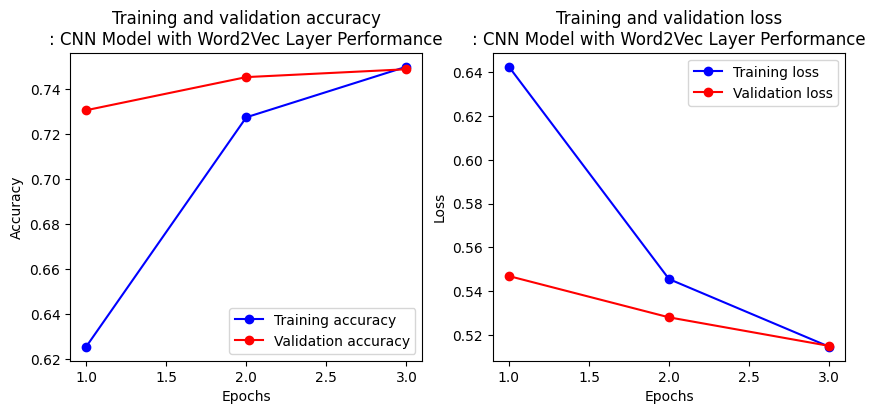

In [33]:
plot_metrics(model1_history, 'Baseline Logistic Regression Model Performance')
plot_metrics(cnn_history, 'Convolutional Neural Network Model Performance')
plot_metrics(cnn_history2, 'CNN Model with Word2Vec Layer Performance')

### Performance Table

In [34]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Function to evaluate a model and return its performance metrics
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=1)
    y_true = y_test.argmax(axis=1)

    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')

    return accuracy, precision, recall, f1

# Assuming you have 4 models already trained
models = [model1, cnn_model2]
model_names = ['Baseline Model', 'CNN Model']

# Collect performance metrics for each model
performance_data = []

for model, name in zip(models, model_names):
    accuracy, precision, recall, f1 = evaluate_model(model, X_test, y_test)
    performance_data.append([name, accuracy, precision, recall, f1])

# Create a DataFrame to display the results
performance_df = pd.DataFrame(performance_data, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

# Print the performance table
print(performance_df)


125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
            Model  Accuracy  Precision  Recall  F1 Score
0  Baseline Model    0.5275   0.529061  0.5275  0.512733
1       CNN Model    0.7345   0.734766  0.7345  0.734489


### ROC-AUC table

125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1 1
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1 1


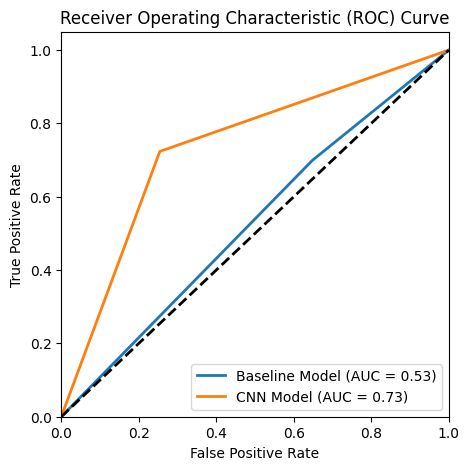

In [35]:
# Function to plot ROC curve for a model

def plot_roc_curve(model, X_test, y_test, model_name, ax):
    if y_test.ndim > 1 and y_test.shape[1] > 1:
      y_test = np.argmax(y_test, axis=1)
    y_pred_proba = np.argmax(model.predict(X_test), axis=1)
    print(y_test[0], y_pred_proba[0])

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Assuming you have 4 models already trained and their names
models = [model1, cnn_model2]
model_names = ['Baseline Model', 'CNN Model']

# Create a plot
fig, ax = plt.subplots(figsize=(5, 5))

# Plot ROC curves for each model
for model, name in zip(models, model_names):
    plot_roc_curve(model, X_test, y_test, name, ax)

# Plot the diagonal line for reference
ax.plot([0, 1], [0, 1], 'k--', lw=2)

# Set plot labels and title
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (ROC) Curve')
ax.legend(loc='lower right')

# Show the plot
plt.show()


### Plot Word Embeddings


In [36]:
# Display the model layers.
display(cnn_model2.layers)

# Retrieve the embeddings layer, which itself is wrapped in a list.
embeddings2 = cnn_model2.layers[0].get_weights()[0]
display(embeddings2.shape)

[<Embedding name=embedding, built=True>,
 <Conv1D name=conv1d, built=True>,
 <MaxPooling1D name=max_pooling1d, built=True>,
 <Flatten name=flatten, built=True>,
 <Dense name=dense, built=True>,
 <Dropout name=dropout, built=True>,
 <Dense name=dense_1, built=True>,
 <Dropout name=dropout_1, built=True>,
 <Dense name=dense_2, built=True>]

(4000, 300)

In [37]:
reverse_index = dict([(value, key) for (key, value) in word_index.items()])
'''
reverse_index[1] = '<START>'  # start of input
reverse_index[2] = '#'        # out-of-vocabulary (OOV)
reverse_index[3] = '<UNUSED>'
'''
max_id = max(reverse_index.keys())
print('Largest ID:', max_id)


Largest ID: 34867


In [38]:
import plotly.graph_objs as go

def plot_2d_embeddings(embeddings, id_start=1, count=100, title="Word Embeddings", x_label="PCA Component 1", y_label="PCA Component 2"):
    # Get 1st and 2nd embedding dims for the desired tokens.
    x1 = embeddings[id_start:id_start+count, 0]
    x2 = embeddings[id_start:id_start+count, 1]

    # Get the corresponding words from the reverse index (for labeling).
    tokens = [reverse_index[i] for i in range(id_start, id_start+count)]

    color_scale = np.linspace(0, 1, count)

    # Plot with the plotly library.
    data = go.Scatter(
        x=x1,
        y=x2,
        text=tokens,
        mode='markers+text',
        textposition='bottom right',
        hoverinfo='text',
        marker=dict(
            size=10,
            color=color_scale,
            colorscale='Viridis',
            showscale=True,
        )
    )

    layout = go.Layout(
        title=title,
        xaxis=dict(title=x_label),
        yaxis=dict(title=y_label),
        hovermode='closest'
    )

    fig = go.Figure(data=[data], layout=layout)
    fig.show()

plot_2d_embeddings(embeddings2,
                   title='Word Embeddings for CNN Model2',
                   id_start=1000,
                   count=100)


### Confusion Matrix

In [39]:
# Create Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    y_true = y_test.argmax(axis=1)

    cf = tf.math.confusion_matrix(y_true, y_pred)
    cf_display = ConfusionMatrixDisplay(cf.numpy())
    cf_display.plot()
    plt.title(title)
    plt.xticks(rotation = 90)
    plt.show()


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


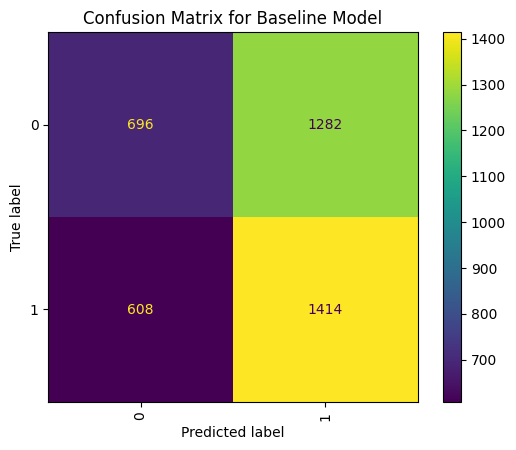

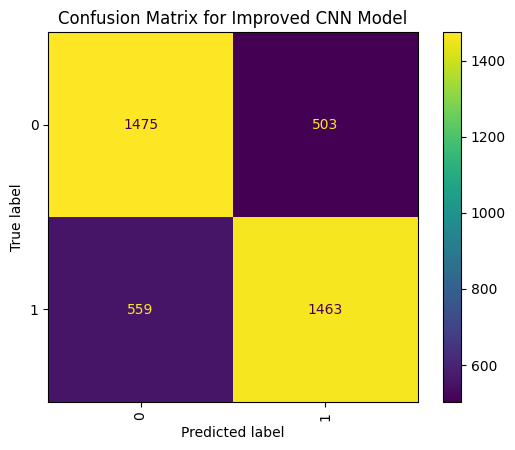

In [40]:
y_pred_baseline = model1.predict(X_test).argmax(axis=1)
y_pred_cnn = cnn_model2.predict(X_test).argmax(axis=1)

plot_confusion_matrix(y_test, y_pred_baseline, title='Confusion Matrix for Baseline Model')
plot_confusion_matrix(y_test, y_pred_cnn, title='Confusion Matrix for Improved CNN Model')

### 🥈 Qualitative Evaluations of The Model

In [42]:
X_train_predicted_probs = cnn_model2.predict(X_train)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


#### On Training Dataset

In [56]:
# Top Positive-rated Tweets from Training Set

high_thresh = 0.995
highest_positives_indices = (X_train_predicted_probs[:,1] > high_thresh)

pos_texts = tokenizer.sequences_to_texts(X_train[highest_positives_indices])

print('Number of tweets rated above', high_thresh, ':', len(pos_texts))
print()
print('Recovered Tweet Texts:')
print('=======================')
for pos_text in pos_texts:
  print(pos_text)

Number of tweets rated above 0.995 : 61

Recovered Tweet Texts:
get followers a day using wwwtweeteraddercom once you add everyone you are on the train or pay vip
my other join favourite song
quoti love you lack of
get followers a day using wwwtweeteraddercom once you add everyone you are on the train or pay vip
get followers a day using wwwtweeteraddercom once you add everyone you are on the train or pay vip
thank you for the nice
hehe thank you
wow he looks hot haha but i still prefer you love days for you in brazil im haha love love love you
thank you thank you thank you well
great day great weather great place great movie great food great people
get followers a day using wwwtweeteraddercom once you add everyone you are on the train or pay vip
get followers a day using wwwtweeteraddercom once you add everyone you are on the train or pay vip
get followers a day using wwwtweeteraddercom once you add everyone you are on the train or pay vip
lol thank you
happy birthday self awww thanks

These don't look very positive, and many of the tweets are the exact same spam text.

In [60]:
# Bottom Positive-rated Tweets from Training Set

low_thresh = 0.0015
lowest_positives_indices = (X_train_predicted_probs[:,1] < low_thresh)

neg_texts = tokenizer.sequences_to_texts(X_train[lowest_positives_indices])

print('Number of tweets rated below', low_thresh, ':', len(neg_texts))
print()
print('Recovered Tweet Texts:')
print('=======================')
for neg_text in neg_texts:
  print(neg_text)

Number of tweets rated below 0.0015 : 17

Recovered Tweet Texts:
kinda sad now that its cancelled i love
looks like the tour is cancelled info pulled from amp am such a shame
cant sleep my head is hurting this sucks
i feel soo sick my throat hurts ears hurt i cant and i have the worst headache ever but i cant sleep ughh
okay am i meant to feel stupid now i dont know whats going on i thought it was tweetdeck was broken
r tweetdeck friends work y search tweetdeck no
omg i order a for and the me to say it their amp amp cancelled the order no
was poor sigh sad sad man
ouch my knee hurts
this cold sucks my throat hurts
burnt down how sad
lost lost lost i miss you i miss talk with u
feeling so pulled out of walk tomorrow cos of me its now totally cancelled so i feel worse amp i fail at
s this tweetdeck is killing me hate it
its a trending topic on tweetdeck but not on
i cried so sad
i left the apple store empty so sad


These do look negative. It is interesting to note that many of these negatives contain the word 'tweetdeck'

In [46]:
# Middle-Rated Tweets from Training Set

mid_positives_indices = np.logical_and((0.499 < X_train_predicted_probs[:,1]), (X_train_predicted_probs[:,1] < 0.501))

mid_texts = tokenizer.sequences_to_texts(X_train[mid_positives_indices])

print('Number of tweets rated between', 0.499, 'and', 0.501, ':', len(mid_texts))
print()
print('Recovered Tweet Texts:')
print('=======================')
for mid_text in mid_texts:
  print(mid_text)

Number of tweets rated between 0.499 and 0.501 : 63

Recovered Tweet Texts:
and em my baby starts what a crazy summer its going to be
center city having breakfast will hit for on the way outta town
i voted and it looks like you are ahead in the
haha im sorry take a nap
had and salad for it was im off going around the block be back soon
seems to be one of those days here too sarah and are both playing instead of
can sum talk me please
yeah i know but in past you could just r to go all the way down
never thought it would come to this but im actually if only i could power a system
listening to loud as fuck couldnt it hope they come back to ireland
argh is out hopefully now keep your fingers for our little i think he does deserve it
oh i know why is so much more i watch im like yeah yeah thats how it happened but why
sleepy up was really friends was great work to and in
will be working the death ride at pass which means i get to see her twice during the ride
hello ive missed ya tonight
ive

Some of these do not feel as neutral as the ratings imply.

#### On Test Dataset

In [61]:
X_test_predicted_probs = cnn_model2.predict(X_test)

125/125 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [63]:
high_thresh = 0.99
highest_positives_indices = (X_test_predicted_probs[:,1] > high_thresh)
pos_texts = tokenizer.sequences_to_texts(X_test[highest_positives_indices])

print('Number of tweets rated above', high_thresh, ':', len(pos_texts))
print()
print('Recovered Tweet Texts:')
print('=======================')
for pos_text in pos_texts:
  print(pos_text)

Number of tweets rated above 0.99 : 9

Recovered Tweet Texts:
happy birthday thank you
love love love its a wonderful thing
enjoying some great sushi lucky very well done
get followers a day using wwwtweeteraddercom once you add everyone you are on the train or pay vip
thanks babe xxxx
thanks for the love
mmm warm tea is so wonderful
thanks hope all enjoy the
done to my can i just tell you how much i appreciate you love you great idea by the way


On the test data, these positive tweets seem much more positive. The spam tweet appears here again.

In [65]:
low_thresh = 0.01
lowest_positives_indices = (X_test_predicted_probs[:,1] < low_thresh)
neg_texts = tokenizer.sequences_to_texts(X_test[lowest_positives_indices])

print('Number of tweets rated below', low_thresh, ':', len(neg_texts))
print()
print('Recovered Tweet Texts:')
print('=======================')
for neg_text in neg_texts:
  print(neg_text)

Number of tweets rated below 0.01 : 19

Recovered Tweet Texts:
my tummy hurts bad like
my throat hurts
all this weekend have been cancelled so it may be or shut for good still trying to find out boo
i hate my job i hate my job
my throat hurts pretty bad
im always depressed because im always sad im always sad because im always bored im always bored because im always here
finally tweetdeck read my blog
i heard about that this morning people sooo sad i cant even imagine just terrible
so sad i was supposed to go to for day but im not anymore
damn just got home for out my stomach hurts
missing out on fire night at so so sad
i had a plan to start working out tomorrow but im feeling sick my head hurts ache back pain and i cant stop no
im missing my online really badly
my eyes still hurts badly
i dont want to be gone i am so sad
is so sad im actually crying aha
im sorry she hasnt here yet either
i have been before its really sad
the show wasnt sad the people who you up were sad


It is interesting to note that these negatives also actually seem more negative than was the case for the training data.

In [66]:
mid_positives_indices = np.logical_and((0.499 < X_test_predicted_probs[:,1]), (X_test_predicted_probs[:,1] < 0.501))
mid_texts = tokenizer.sequences_to_texts(X_test[mid_positives_indices])

print('Number of tweets rated between', 0.499, 'and', 0.501, ':', len(mid_texts))
print()
print('Recovered Tweet Texts:')
print('=======================')
for mid_text in mid_texts:
  print(mid_text)

Number of tweets rated between 0.499 and 0.501 : 8

Recovered Tweet Texts:
nope we dont as wouldnt be a good thing lol
why do you always say something that makes me worry about you
will always be waiting
even behind my ears you look too
more wake looks interesting and there is a release window too maybe it is not after all
date we gone to instead
dont think i am going to go to see today as dad wants me to
of not good free p


On the test data, we also see that the true sentiments of these tweets in the 'neutral' zone don't fully match up with their sentiment ratings from the model.